In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from os import path

from datetime import datetime
import re

# API wrapper for country information
from restcountries import RestCountryApiV2 as api

# Plotting library
import plotly as py
from plotly.graph_objs import *

# Graph manipulation library
import networkx as nx

# Interactive maps
import folium
from folium.plugins import MarkerCluster
from branca.colormap import linear

# Word cloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline
py.offline.init_notebook_mode(connected=True)

## Abstract

Seemingly whimsical, the title of this project encloses the harsh reality of how astoundingly primitive we are in the 21st century and how little has actually changed since Medieval times. We attempt to modernise our society in many aspects, invent new technology to make everyday life more pleasant, but at the end of the day, we witness so much violence, intolerance and hatred. Independent of the fact whether it is an inter-country conflict for territory, an organisation requesting rights, a state or region fighting for independence, the truth is these clashes result in numerous casualties, direct or collateral, ruined societies, destroyed lives and terrible loss. And there are much more sparkles on the edge of kindling a fire.

The goal of this project is to make an attempt at uncovering the shocking reality about world conflicts that few people know about because it may not be or have been in the spotlight. Hopefully, observing the aggregated information visualised in a nicely presentable way will help raise awareness of what has been happening in recent history or at the present moment, and bring incentive to start building an improved version of the World.

<i>The project website and data story is available on the following link: https://vjan-fin.github.io./.</i>

## Loading the data and getting familiar with it

In [2]:
DATA_PATH = './data/'

# Primary datasets of interest
ucdp_ged_global_file = os.path.join(DATA_PATH + 'ged171.csv')
ucdp_armed_conflicts_file = os.path.join(DATA_PATH + 'ucdp-prio-acd-171.csv')
ucdp_nonstate_conflicts_file = os.path.join(DATA_PATH + 'ucdp-nonstate-171.csv')
ucdp_battle_deaths_file = os.path.join(DATA_PATH + 'ucdp-brd-conf-171.csv')

# Additional datasets
ucdp_conflict_offset_file = os.path.join(DATA_PATH + 'ucdp-onset-conf-2014.csv')

# Metadata datasets
ucdp_actor_list_file = os.path.join(DATA_PATH + 'actorlist.csv')
gleditsch_ward_file = os.path.join(DATA_PATH + 'gleditsch-ward.txt')

### UCDP Georeferenced Event Dataset (GED) Global version 17.1 (2016)

This dataset is UCDP's most disaggregated dataset, covering individual events of organized violence (phenomena of lethal violence occurring at a given time and place). These events are sufficiently fine-grained to be geo-coded down to the level of individual villages, with temporal durations disaggregated to single, individudal days.

The basic unit of analysis for the UCDP GED dataset is the “event”, i.e. an individual incident (phenomenon) of lethal violence occurring at a given time and place. The dataset covers the entire World (except Syria) between 01.01.1989 and 31.12.2016.

Data in the UCDP GED is geo-referenced, meaning that each event is connected to a specific location defined by a pair of latitude and longitude coordinates. Each event is connected to a single location.

This dataset will be useful in tackling the research questions proposed for the project concerning the number of battle-related deaths for a particular location, the casualties suffered by each of the opposing sides in a conflict, but also civilians, and it will help us precisely pinpoint the locations of the battle sites that resulted in a significant amount of victims.

In terms of battle-related deaths, this dataset is a better option than the UCDP Battle-Related Deaths Dataset to get a more precise number on the losses suffered by each opposing side as it gives a disaggregated per-event number of casualties instead of an annual sum. It also provides information of the territory on which the deaths were registered.


<b>1. Dataset attributes</b>

<table>
    <tr>
        <th>Variable name</th>
        <th>Type</th>
        <th>Meaning</th>
    </tr>
    <tr>
        <td>year</td>
        <td>int</td>
        <td>The year of the event</td>
    </tr>
    <tr>
        <td>active_year</td>
        <td>int (categorical)</td>
        <td>If the event belongs to an active conflict/dyad/actor-year or otherwise.</td>
    </tr>
    <tr>
        <td>type_of_violence</td>
        <td>int (categorial)</td>
        <td>Type of UCDP conflict: state-based conflict, non-state conflict or one-sided violence</td>
    </tr>
    <tr>
        <td>conflict_name</td>
        <td>string</td>
        <td>Name of the UCDP conflict to which the event belongs. For non-state conflicts and one-sided violence this is the same as the dyad name</td>
    </tr>
    <tr>
        <td>dyad_new_id</td>
        <td>int</td>
        <td>A unique conflict identification code for each individual dyad in the dataset.</td>
    </tr>
    <tr>
        <td>dyad_name</td>
        <td>string</td>
        <td>Name of the conflict dyad creating the event. A definition of <i>dyad</i> is provided in the following section.</td>
    </tr>
    <tr>
        <td>side_a</td>
        <td>string</td>
        <td>The name of Side A in the dyad. In state-based conflicts always a government. In one-sided violence always the perpetrating party.</td>
    </tr>
    <tr>
        <td>side_b</td>
        <td>string</td>
        <td>The name of Side B in the dyad. In state-based always the rebel movement or rivalling government. In one-sided violence always “civilians”.</td>
    </tr>
    <tr>
        <td>where_prec</td>
        <td>int (categorical)</td>
        <td>The precision with which the coordinates and location assigned to the event reflects the location of the actual event.</td>
    </tr>
    <tr>
        <td>where_coordinates</td>
        <td>string</td>
        <td>Name of the location to which the event is assigned.</td>
    </tr>
    <tr>
        <td>adm_1</td>
        <td>string</td>
        <td>Name of the first order (largest) administrative division where the event took place.</td>
    </tr>
    <tr>
        <td>adm_2</td>
        <td>string</td>
        <td>Name of the second order administrative division where the event took place.</td>
    </tr>
    <tr>
        <td>latitude</td>
        <td>numeric</td>
        <td>Latitude (in decimal degrees).</td>
    </tr>
    <tr>
        <td>longitude</td>
        <td>numeric</td>
        <td>Longitude (in decimal degrees).</td>
    </tr>
    <tr>
        <td>country</td>
        <td>string</td>
        <td>Name of the country in which the event takes place.</td>
    </tr>
    <tr>
        <td>region</td>
        <td>string (categorical)</td>
        <td>Region where the event took place. One of following: Africa, Americas, Asia, Europe, Middle East.</td>
    </tr>
    <tr>
        <td>date_start</td>
        <td>date(YYYY-MM-DD)</td>
        <td>The earliest possible date when the event has taken place.</td>
    </tr>
    <tr>
        <td>date_end</td>
        <td>date(YYYY-MM-DD)</td>
        <td>The last possible date when the event has taken place.</td>
    </tr>
    <tr>
        <td>deaths_a</td>
        <td>integer</td>
        <td>The best estimate of deaths sustained by side a. Always 0 for one-sided violence events.</td>
    </tr>
    <tr>
        <td>deaths_b</td>
        <td>integer</td>
        <td>The best estimate of deaths sustained by side b. Always 0 for one-sided violence events</td>
    </tr>
    <tr>
        <td>deaths_civilians</td>
        <td>integer</td>
        <td>The best estimate of dead civilians in the event. For non-state or state-based events, this is the number of collateral damage resulting in fighting between side a and side b. For one-sided violence, it is the number of civilians killed by side a.</td>
    </tr>
    <tr>
        <td>deaths_unknown</td>
        <td>integer</td>
        <td>The best estimate of deaths of persons of unknown status.</td>
    </tr>
    <tr>
        <td>best_est</td>
        <td>integer</td>
        <td>The best (most likely) estimate of total fatalities resulting from an event. It is always the sum of deaths_a, deaths_b, deaths_civilians and deaths_unknown.</td>
    </tr>
    <tr>
        <td>high_est</td>
        <td>integer</td>
        <td>The highest reliable estimate of total fatalities.</td>
    </tr>
    <tr>
        <td>low_est</td>
        <td>integer</td>
        <td>The lowest reliable estimate of total fatalities.</td>
    </tr>
</table>

A large number of the variables presented in the table reappear in the other datasets as well and will not be analysed again later, unless there is a change in the name of the variable, the semantics or the methodology how its value was collected.

<b>2. Terminology and definitions</b>

This subsection attempts to clarify some of the prerequisites and terminology required to better understand the provided data and to interpret the results more accurately.

  * <b>Event</b> = <i>An incident where armed force was by an <b>organised actor</b> against <b>another organized actor, or against civilians, resulting in at least 1 direct death</b> at a <b>specific location</b> and a <b>specific date</b></i>
  * <b>Armed force</b> = <i>Use of arms in order to promote the parties’ general position in the conflict, resulting in deaths</i>
  * <b>Organized actor</b> = <i>A government of an independent state, a formally organized group or an informally organized group</i>
  * <b>Dyad</b> = <i>A dyad is the <b>pair of two armed and opposing actors engaged in violence</b> (in the case of one-sided violence, the perpetrator of violence and civilians).</i>
  * <b>Active conflict</b> = <i>A conflict, both state-based and non-state, is deemed to be active if there are <b>at least 25 battle-related deaths per calendar year</b> in one of the conflict’s dyads.</i>
  * <b>Incompatibility</b> = <i>The stated (in writing or verbally) generally incompatible positions.</i>

In [3]:
# Map certain column values into more meaningful categories
active_year_map = {
    1: 'active',
    0: 'non-active'
}

type_of_violence_map = {
    1: 'state-based',  # government vs. formally organised group
    2: 'non-state',  # formally organised group vs. formally organised group OR informally organised group vs. formally organised group
    3: 'one-sided'  # formally organised group vs. civilians
}

where_prec_map = {
    1: 'exact',
    2: '25km radius',
    3: 'second order administrative division',  # district, municipality or commune
    4: 'first order administrative division',  # province, state or governorate
    5: 'linear region',  # along a border or a river
    6: 'country',
    7: 'international waters'
}

ged_global_columns = ['year', 'active_year', 'type_of_violence', 
                      'conflict_new_id', 'conflict_name', 'dyad_new_id', 'dyad_name',
                      'side_a_new_id', 'side_b_new_id', 'where_prec', 'where_coordinates',
                      'adm_1', 'adm_2', 'latitude', 'longitude', 'country', 'region',
                      'date_start', 'date_end', 'deaths_a', 'deaths_b', 'deaths_civilians',
                      'deaths_unknown', 'best', 'low', 'high'
                     ]

In [4]:
ged_global_raw = pd.read_csv(ucdp_ged_global_file, sep=',', header=0, index_col='id', na_values=-99)
ged_global_raw.replace({
    'active_year': active_year_map,
    'type_of_violence': type_of_violence_map,
    'where_prec': where_prec_map
}, inplace=True)

ged_global_raw = ged_global_raw[ged_global_columns]

In [5]:
ged_global_raw.shape

(135181, 26)

In [6]:
ged_global_raw['conflict_new_id'].nunique()

997

The dataset contains 135'181 events of organised violence, which are part of a total of 997 unique conflicts that occurred during the period 1989-2016.

In [7]:
ged_global_raw.isnull().sum()

year                     0
active_year              0
type_of_violence         0
conflict_new_id          0
conflict_name            0
dyad_new_id              0
dyad_name                0
side_a_new_id            0
side_b_new_id            0
where_prec               0
where_coordinates        0
adm_1                 7060
adm_2                35871
latitude                 0
longitude                5
country                  0
region                   0
date_start               0
date_end                 0
deaths_a                 0
deaths_b                 0
deaths_civilians         0
deaths_unknown           0
best                     0
low                      0
high                     0
dtype: int64

It is very important that the dataset does not have missing values for the key attributes that we intend to use. Those are the ones related to geographical location of the conflict event and battle-related deaths.

### UCDP Actor List

A simple list of all the actors (including their full names and alternate names) as available in UCDP datasets version 17.1.

This dataset will be very useful in the process of mapping the acronyms of many organised groups to their full names.

In [8]:
actor_list_raw = pd.read_csv(ucdp_actor_list_file, sep=',', header=0, index_col='ActorID')

In [9]:
actor_list_raw.shape

(1687, 2)

In [10]:
actor_list_raw.isnull().sum()

Name         0
NameFull    26
dtype: int64

The full dataset consists of 1'687 actors, each described with a unique ID, a name and a full name. However, 26 of the actors are missing a value for the full name entry. In order to cope with this issue in advance, rather than check if the values exist later in the analysis, the `Name` value will be copied to the `NameFull` column wherever there is a missing value.

In [11]:
nan_row_indices = actor_list_raw[actor_list_raw['NameFull'].isnull()].index
actor_list_raw.loc[nan_row_indices, 'NameFull'] = actor_list_raw.loc[nan_row_indices, 'Name']
actor_list_raw.loc[nan_row_indices]

,Name,NameFull
ActorID,,
3821,"France, Israel, United Kingdom","France, Israel, United Kingdom"
3823,"Egypt, Iraq, Jordan, Lebanon, Syria","Egypt, Iraq, Jordan, Lebanon, Syria"
3835,"Bokora Karimojong, Pian Karimojong","Bokora Karimojong, Pian Karimojong"
3856,"Lendu, RCD-K-ML","Lendu, RCD-K-ML"
3864,"Serbian irregulars, Serbian Republic of Bosnia...","Serbian irregulars, Serbian Republic of Bosnia..."
3881,"Afar, Oromo","Afar, Oromo"
3883,"Supporters of ANC, Supporters of UDF","Supporters of ANC, Supporters of UDF"
3894,"Goldia, Mursi","Goldia, Mursi"
3898,"Forces of Hasan, Musa Shajik","Forces of Hasan, Musa Shajik"


### UCDP/PRIO Armed Conflict Dataset version 17.1

A conflict-year dataset with information on armed conflicts where at least one party is the government of a state in the time period 1946-2016.

The main unit in this dataset is an “Armed Conflict” as defined by UCDP. Each conflict is listed in the database and given a unique ID code. The definition of armed conflict is given in the Terminology and definitions section below.

The observation (or unit) in the Main Conflict table is the conflict-year. Each conflict is listed in all years where fighting in one or more dyad(s) caused at least 25 battle-related deaths.

<b>1. Dataset attributes</b>

<table>
    <tr>
        <th>Variable name</th>
        <th>Type</th>
        <th>Meaning</th>
    </tr>
    <tr>
        <td>location</td>
        <td>string</td>
        <td>The name(s) of the country/countries whose government(s) have a primary claim to the issue in dispute. Location is defined as the government side of a conflict, and should not be interpreted as the geographical location of the conflict.</td>
    </tr>
    <tr>
        <td>Incomp</td>
        <td>int (categorical)</td>
        <td>A general coding of the conflict issue. The possible values are: territory, government, and government and territory.</td>
    </tr>
    <tr>
        <td>int</td>
        <td>int (categorical)</td>
        <td>The intensity level in the dyad per calendar year. Two different intensity levels are coded: minor armed conflicts and wars.</td>
    </tr>
    <tr>
        <td>cumint</td>
        <td>int (categorical)</td>
        <td>The intensity of the conflict, taking into consideration the conflict history. Indicates whether the conflict since the onset has exceeded 1,000 battle-related deaths.</td>
    </tr>
    <tr>
        <td>type</td>
        <td>int (categorical)</td>
        <td>Four different types of conflict: extrasystemic, interstate, internal and internationalized internal.</td>
    </tr>
    <tr>
        <td>startdate</td>
        <td>date (YYYY-MM-DD)</td>
        <td>The date, as precise as possible, of the first battle-related death in the conflict.</td>
    </tr>
    <tr>
        <td>startdate2</td>
        <td>date (YYYY-MM-DD)</td>
        <td>The date, as precise as possible, when a given episode of conflict activity reached 25 battle-related deaths in a year.</td>
    </tr>
    <tr>
        <td>ependate</td>
        <td>date (YYYY-MM-DD)</td>
        <td>The date, as precise as possible, when conflict activity ended.</td>
    </tr>
    <tr>
        <td>region</td>
        <td>int (categorical)</td>
        <td>Identifying the region of the location.</td>
    </tr>
</table>

<b>2. Terminology and definitions</b>

  * <b>Armed conflict</b> = <i>a contested incompatibility that concerns government and/or territory where the use of armed force between two parties, of which at least one is the government of a state, results in <b>at least 25 battle-related deaths</b> in one calendar year. “Armed conflict” is also referred to as “state-based conflict”, as opposed to “non-state conflict”, in which none of the warring parties is a government.</i>
  * <b>Minor conflict</b> = <i>Between 25 and 999 battle-related deaths in a given year.</i>
  * <b>War</b> = <i>At least 1,000 battle-related deaths in a given year.</i>
  * <b>Extrasystemic armed conflict</b> = <i>Occurs between a state and a non-state group outside its own territory. These conflicts are by definition territorial, since the government side is fighting to retain control of a territory outside the state system.</i>
  * <b>Interstate armed conflict</b> = <i>Occurs between two or more states.</i>
  * <b>Internal armed conflict</b> = <i>Occurs between the government of a state and one or more internal opposition group(s) without intervention from other states.</i>
  * <b>Internationalized internal armed conflict</b> = <i>Occurs between the government of a state and one or more internal opposition group(s) with intervention from other states (secondary parties) on one or both sides.</i>

In [12]:
# Map certain column values into more meaningful categories
incomp_map = {
    1: 'territory',
    2: 'government',
    3: 'government and territory'
}

intensity_map = {
    1: 'minor',  # between 25 and 999 battle-related deaths in a given year
    2: 'war'  # at least 1'000 battle-related deaths in a given year
}

cumint_map = {
    0: 'minor',  # between 25 and 999 battle-related deaths for the entire conflict period
    1: 'war'  # more than 1'000 battle-related deaths for the entire conflict period
}

type_map = {
    1: 'extrasystemic',  # between a state and a non-state group outside its own territory
    2: 'interstate',  # between two or more states
    3: 'internal',  # between the government of a state and one or more internal opposition group(s) without intervention from other states
    4: 'internationalized'  # between the government of a state and one or more internal opposition group(s) with intervention from other states on one or both sides
}

region_map = {
    '1': 'Europe',
    '2': 'Middle East',
    '3': 'Asia',
    '4': 'Africa',
    '5': 'Americas'
}

armed_conflicts_columns = ['conflictid', 'location', 'sidea', 'side b' , 'sidebid',
                      'incomp', 'year', 'intensity', 'cumint', 'type',
                      'startdate', 'startdate2', 'ependdate', 'region'
                     ]

In [13]:
armed_conflicts_raw = pd.read_csv(ucdp_armed_conflicts_file, sep=',', header=0, na_values=-99)
armed_conflicts_raw.replace({
    'incomp': incomp_map,
    'intensity': intensity_map,
    'cumint': cumint_map,
    'type': type_map,
    'region': region_map
}, inplace=True)

# Handle the case where there are multiple regions in the same cell - all of them need to be mapped
for key in region_map.keys():
    armed_conflicts_raw['region'] = armed_conflicts_raw['region'].str.replace(r'(%s,?)' % (key), '%s,' % (region_map[key]))
armed_conflicts_raw['region'] = armed_conflicts_raw['region'].str.rstrip(',')

armed_conflicts_raw = armed_conflicts_raw[armed_conflicts_columns]
armed_conflicts_raw.shape

(2277, 14)

In [14]:
armed_conflicts_raw.head(10)

,conflictid,location,sidea,side b,sidebid,incomp,year,intensity,cumint,type,startdate,startdate2,ependdate,region
0,200,Bolivia,Government of Bolivia,Popular Revolutionary Movement,719,government,1946,war,war,internal,1946-07-18,1946-07-21,1946-07-21,Americas
1,200,Bolivia,Government of Bolivia,MNR,720,government,1952,minor,war,internal,1946-07-18,1952-04-09,1952-04-12,Americas
2,200,Bolivia,Government of Bolivia,ELN,721,government,1967,minor,war,internal,1946-07-18,1967-03-31,1967-10-16,Americas
3,201,Cambodia (Kampuchea),Government of France,Khmer Issarak,160,territory,1946,minor,minor,extrasystemic,1946-08-31,1946-08-31,NaN,Asia
4,201,Cambodia (Kampuchea),Government of France,Khmer Issarak,160,territory,1947,minor,minor,extrasystemic,1946-08-31,1946-08-31,NaN,Asia
5,201,Cambodia (Kampuchea),Government of France,Khmer Issarak,160,territory,1948,minor,minor,extrasystemic,1946-08-31,1946-08-31,NaN,Asia
6,201,Cambodia (Kampuchea),Government of France,Khmer Issarak,160,territory,1949,minor,minor,extrasystemic,1946-08-31,1946-08-31,NaN,Asia
7,201,Cambodia (Kampuchea),Government of France,Khmer Issarak,160,territory,1950,minor,minor,extrasystemic,1946-08-31,1946-08-31,NaN,Asia
8,201,Cambodia (Kampuchea),Government of France,Khmer Issarak,160,territory,1951,minor,minor,extrasystemic,1946-08-31,1946-08-31,NaN,Asia
9,201,Cambodia (Kampuchea),Government of France,Khmer Issarak,160,territory,1952,minor,minor,extrasystemic,1946-08-31,1946-08-31,NaN,Asia


In [15]:
armed_conflicts_raw['conflictid'].nunique()

280

The Armed Conflict Dataset contains a total of 2'277 rows described by 27 attributes. Since the included data revolves around the concept of a `conflict`, multiple rows in the dataset describing one particular episode may refer to the same conflict which is primarily identified by the incompatibility between the opposing sides. Therefore, the `conflictid` column values are not unique. In fact, the dataset describes a total of 280 unique conflicts in the period 1946-2016.

In [16]:
armed_conflicts_raw.isnull().sum()

conflictid       0
location         0
sidea            0
side b           0
sidebid          0
incomp           0
year             0
intensity        0
cumint           0
type             0
startdate        0
startdate2       0
ependdate     1753
region           0
dtype: int64

The dataset does not include unclear conflicts where information on key variables to the definition of conflict is uncertain or missing. Key variables are those related to the incompatibility, actors and intensity.

### UCDP Non-State Conflict Dataset

The dataset is an equivalent of the UCDP/PRIO Armed Conflict Dataset version 17.1 but contains data for non-state conflicts for the period 1989-2016. The definition of the different types of violence can be found in the definitions subsection.

<b>1. Dataset attributes</b>

<table>
    <tr>
        <th>Variable name</th>
        <th>Type</th>
        <th>Meaning</th>
    </tr>
    <tr>
        <td>org</td>
        <td>int (categorical)</td>
        <td>This variable indicates the organizational level of the warring sides.</td>
    </tr>
</table>

<b>2. Terminology and definitions</b>

  * <b>Non-state conflict</b> = <i>The use of armed force between two organized armed groups, neither of which is the government of a state, which results in at least 25 battle-related deaths in a year.</i> 
  * <b>Formally organized group</b> = <i>Any non-governmental group of people having announced a name for their group and using armed force against another similarly formally organized group.</i>
  * <b>Informally organized group</b> = <i>Any group without an announced name, but who uses armed force against another similarly organized group, where there is a clear pattern of violent incidents that are connected and
in which both groups use armed force against the other</i>
  * <b>State</b> = <i>An internationally recognized sovereign government controlling a specified territory or an internationally unrecognized government controlling a specified territory whose sovereignty is not disputed by another internationally recognized sovereign government previously controlling the same territory.</i>
  * <b>Government</b> = <i>The party controlling the capital of the state.</i>

In [17]:
# Map certain column values into more meaningful categories
org_map = {
    1: 'formal-groups',
    2: 'informal-groups',
    3: 'ad-hoc-groups'
}

region_map = {
    1: 'Europe',
    2: 'Middle East',
    3: 'Asia',
    4: 'Africa',
    5: 'Americas'
}

nonstate_conflicts_columns = ['conflictid', 'org', 'sideaname', 'sideaid', 'sidebname', 'sidebid', 
                              'year', 'fatbest', 'fatlow', 'fathigh', 'location', 'region']

In [18]:
nonstate_conflicts_raw = pd.read_csv(ucdp_nonstate_conflicts_file, sep=',', header=0, na_values=-99)
nonstate_conflicts_raw.replace({
    'org': org_map,
    'region': region_map
}, inplace=True)

# Handle the case where there are multiple regions in the same cell - all of them need to be mapped
for key in region_map.keys():
    nonstate_conflicts_raw['region'] = nonstate_conflicts_raw['region'].str.replace(r'(%s,?)' % (key), '%s,' % (region_map[key]))
nonstate_conflicts_raw['region'] = nonstate_conflicts_raw['region'].str.rstrip(',')

nonstate_conflicts_raw = nonstate_conflicts_raw[nonstate_conflicts_columns]
nonstate_conflicts_raw.shape

(1000, 12)

In [19]:
nonstate_conflicts_raw.head(10)

,conflictid,org,sideaname,sideaid,sidebname,sidebid,year,fatbest,fatlow,fathigh,location,region
0,4564,formal-groups,1920 Revolution Brigades,783,IS,234,2007,25,25,25,Iraq,Middle East
1,4565,ad-hoc-groups,Abgal clan (Hawiye),1028,Xawaadle clan (Hawiye),891,2008,31,31,55,Somalia,Africa
2,4566,ad-hoc-groups,Abudu,570,Andani,892,2002,36,25,40,Ghana,Africa
3,4567,informal-groups,Supporters of ACN,893,Supporters of PDP,668,2008,33,33,33,Nigeria,Africa
4,4567,informal-groups,Supporters of ACN,893,Supporters of PDP,668,2011,26,26,46,Nigeria,Africa
5,4568,informal-groups,Supporters of AD,571,Supporters of PDP,668,2003,29,29,36,Nigeria,Africa
6,4569,ad-hoc-groups,Afar,572,Kereyou,635,2002,29,29,29,Ethiopia,Africa
7,4569,ad-hoc-groups,Afar,572,Kereyou,635,2003,40,40,40,Ethiopia,Africa
8,4570,ad-hoc-groups,Afar,572,Issa,624,2002,75,75,248,Ethiopia,Africa
9,4571,ad-hoc-groups,Abtisame subclan of Galje'el clan (Hawiye),569,Afi subclan of Galje'el clan (Hawiye),573,2004,26,26,30,Somalia,Africa


In [20]:
nonstate_conflicts_raw['conflictid'].nunique()

624

The Non-state Conflict Dataset contains a total of 1'000 rows described by 12 attributes. Since the included data revolves around the concept of a conflict, multiple rows in the dataset describing one particular episode may refer to the same conflict which is primarily identified by the incompatibility between the opposing sides. Therefore, the conflictid column values are not unique. In fact, the dataset describes a total of 624 unique conflicts in the period 1989-2016.

In [21]:
nonstate_conflicts_raw.isnull().sum()

conflictid    0
org           0
sideaname     0
sideaid       0
sidebname     0
sidebid       0
year          0
fatbest       0
fatlow        0
fathigh       0
location      0
region        0
dtype: int64

The dataset does not require any kind of missing value handling

### UCDP Battle-Related Deaths Dataset

Each entry in the dataset contains one side A (the contested party) and one or more contesters in a given year (each entry being one contested incompatibility) over the period 1989-2016. Thus, each individual conflict has its individual entry.

The advantage of working with this dataset instead of just using UCDP Georeferenced Event Dataset (GED) Global version 17.1 (2016) is that it is much easier to obtain totals, visualise annual trends and build a timeline of the battle victims over the years.

The main purpose of including this dataset is to obtain an aggregated value of the battle-related deaths over the years a particular conflict was active. Therefore, the columns that are present in the previously loaded datasets and are not absolutely necessary for the conflict casualties analysis will be discarded.

<b>1. Dataset attributes</b>

<table>
    <tr>
        <th>Variable name</th>
        <th>Type</th>
        <th>Meaning</th>
    </tr>
    <tr>
        <td>BattleLocation</td>
        <td>string</td>
        <td>The name of the country/countries in which battle-related deaths have been reported in the conflict.</td>
    </tr>
</table>

<b>2. Terminology and definitions</b>

  * <b>Best estimate</b> = <i>The UCDP Best estimate consist of the aggregated most reliable numbers for all battle-related incidents during a year. If different reports provide different estimates, an examination is made as to what source is most reliable. If no such distinction can be made, UCDP as a rule include the lower figure given.</i>
  * <b>Low estimate</b> = <i>The UCDP Low estimate consists of the aggregated low estimates for all battle-related incidents during a year. If different reports provide different estimates and a higher estimate is considered more reliable, the low estimate is also reported if deemed reasonable.</i>
  * <b>High estimate</b> = <i>The UCDP High estimate consists of the aggregated high estimates for all battle-related incidents during a year as listed in UCDP GED. If different reports provide different estimates and a lower estimate is considered more or equally reliable, the high estimate is also reported if deemed reasonable. If there are incidents when there is some uncertainty about what parties have been involved, these are also included in the high estimate.</i>

In [22]:
battle_deaths_columns = ['ConflictID', 'Year', 'LocationInc', 'BdBest', 'BdLow', 'BdHigh', 'BattleLocation']

In [23]:
battle_deaths_raw = pd.read_csv(ucdp_battle_deaths_file, sep=',', header=0, na_values=-99)
battle_deaths_raw = battle_deaths_raw[battle_deaths_columns]
battle_deaths_raw.shape

(1113, 7)

In [24]:
battle_deaths_raw.head(10)

,ConflictID,Year,LocationInc,BdBest,BdLow,BdHigh,BattleLocation
0,13349,2013,Myanmar (Burma),29,29.0,30,Myanmar (Burma)
1,13349,2014,Myanmar (Burma),37,37.0,203,Myanmar (Burma)
2,13349,2015,Myanmar (Burma),106,106.0,181,Myanmar (Burma)
3,13721,2015,Algeria,26,26.0,26,Algeria
4,13692,2001,"Afghanistan, United Kingdom, United States of ...",1490,1482.0,2259,Afghanistan
5,13641,2016,Nigeria,2213,2210.0,2311,Nigeria
6,13641,2015,Nigeria,1919,1916.0,2953,Nigeria
7,11342,2012,India,27,23.0,27,India
8,11342,2014,India,26,23.0,32,India
9,11344,2011,Sudan,145,145.0,145,Sudan


In [25]:
battle_deaths_raw['ConflictID'].nunique()

171

The Battle-Related Deaths Dataset contains a total of 1'113 rows. Much like in the case for the Armed Conflict Dataset, what defines a conflict are the incompatibilities between two sides, which means the `ConflictID` column does not necessarily contain unique values. In fact, the dataset describes a total of 171 unique conflicts in the period 1989-2016.

In [26]:
battle_deaths_raw[['BdBest', 'BdLow', 'BdHigh']].isnull().sum()

BdBest    0
BdLow     1
BdHigh    0
dtype: int64

The previous code snippet reveals there is a single NaN or missing value in the `BdLow` column and none in the other two numeric columns. Since it is only one case, it is feasible to examine it and set a value manually. There is no need for a general strategy.

In [27]:
battle_deaths_raw[battle_deaths_raw['BdLow'].isnull()]

,ConflictID,Year,LocationInc,BdBest,BdLow,BdHigh,BattleLocation
384,299,2014,Syria,54547,NaN,63887,"Lebanon, Syria"


In [28]:
battle_deaths_raw[battle_deaths_raw['ConflictID'] == 299]

,ConflictID,Year,LocationInc,BdBest,BdLow,BdHigh,BattleLocation
380,299,2016,Syria,27235,15664.0,27235,Syria
381,299,2011,Syria,965,912.0,1190,Syria
382,299,2012,Syria,38480,14893.0,38709,"Syria, Turkey"
383,299,2013,Syria,68503,7529.0,68503,"Iraq, Lebanon, Syria"
384,299,2014,Syria,54547,NaN,63887,"Lebanon, Syria"
385,299,2015,Syria,33967,20057.0,33967,"Jordan, Syria"


The missing values appears to concern the annual battle-deaths low estimate for a battle which was part of the war in Syria and that played out on Syrian and Lebanese territory during the year 2014. As the best estimate value is not missing, it would not cause significant damage to replace the missing with the `BdBest` from the same row. Setting `BdLow` to zero will cause too much of an offset. It can be clearly seen from the other years that the number of casualties is never even close to zero. On the other hand, it is obvious even without any analysis that there is no increasing or decreasing trend that can be used for the estimate, therefore the best option is to simply replace the value with the upper-bound, which is exactly the value of `BdBest`.

In [29]:
battle_deaths_raw.loc[384, 'BdLow'] = battle_deaths_raw.loc[384, 'BdBest']

In [30]:
battle_deaths_raw[['BdLow', 'BdBest', 'BdHigh']].quantile([0, 0.25, 0.5, 0.75, 1])

,BdLow,BdBest,BdHigh
0.00,6.0,25.0,24.0
0.25,52.0,55.0,80.0
0.50,168.0,179.0,272.0
0.75,699.0,751.0,1100.0
1.00,54547.0,68503.0,68503.0


In [31]:
battle_deaths_raw[['BdLow', 'BdBest', 'BdHigh']].sum()

BdLow     1121604.0
BdBest    1287186.0
BdHigh    1667203.0
dtype: float64

The rows of this output give 5 quantile values, among which the minimum (0% quantile) and the maximum (100% quantile) values for each column. The other statistics do not make much sense, since the data first needs to be aggregated in order to draw any significant conclusions. The minimum and the maximum represent the annual number of battle-related deaths for a single conflict based on the corresponding estimate (low, best or high).

The shocking figures are the ones for the sum of each of these three columns. The number of battle-related deaths over a period of 28 years (1989-2016) falls in the range [1'121'604, 1'667'203], with the best estimate being 1'287'186 deaths.

### UCDP Conflict Termination Dataset version 2-2015

As part of the first milestone, we mentioned that we would use the UCDP Conflict Termination Dataset version 2-2015 in order to enrich the datasets described above, but after a more detailed examination of the potential of the previously listed datasets, we decided they provide all the needed information for the scope of the project. It would be best to simply use the information of whether conflicts are active or not in a particular year, in addition to the date of the conflict offset. Going into the peace aggreements into too much detail might cause a loss of focus, which we do not want. Therefore, the UCDP Conflict Termination Dataset version 2-2015 will not be used.

### Summary of the data collection process

The subsections above represent an extensive analysis of the global conflicts datasets provided on the UCDP website. It is worth noticing that even though they are "real-world" datasets, they lack the disorder, chaoticity and general "messiness" that other datasets usually encompass. This is understandable if we look into the background, into the data collection process which was done by professionals, researchers who used well-precised methodologies and invested a non-negligible amount of work into the correctness of the provided data. Therefore, quite honestly, much of the standard preprocessing steps were unnecessary as they were either already applied or simply those issues were nonexistant.

For every dataset we explored whether any of the features of interest contained any missing values and luckily there was only one single case that required attention and a strategy to fill in some NaNs. Everything else boiled down to the analysis of the dataset size, the type of the variables, the ranges of the variables where we judged useful to have that information and the number of unique observed events.

As the data is rather small in its volume, quite comprehensible without the need of significant computational power, surprisingly clean and consistent, and very well documented and described, the biggest challenge was to get familiar with the terminology and the meaning of the features that are used to describe the data. After extensive reading of the so-called "codebooks" that accompany every dataset, we put together tables explaining the used variables accross the different datasets, stating the name, the type and a detailed meaning, as this is crucial to understand how and why some steps are made or some decisions are taken. Furthermore, we give definition of some of the jargon that is used throughout the project. For each dataset we also briefly discuss the necessity of it and the reasons it was chosen in terms of the intentions we have for the next milestone.

As stated in the abstract itself, the purpose of this project is to aggregate and analyse the data, draw conclusions and use different visualisation techniques in order to present them in a way that will make it very easy for the reader to understand the point. We will not dive into supervised or unsupervised learning techniques, but rather employ data visualisation such as graphs, network diagrams, maps and other plots to discover the relationships between the conflict actors, to collect and display all the information contained in the different datasets in one place.

## Conflict episode analysis on a regional aggregation basis

As a first step, we will use the Armed Conflict Dataset to obtain insight on the conflict activity in different geographical areas of the World. In this section we will explore the number and the kind of armed conflicts, judging by the intensity, on a regional level, which constitutes a territory size similar to an entire continent or large part of a continent, and in the next section we will dive deeper into a more granular analysis based on the location where the conflict episodes have occurred.

The Armed Conflict Dataset aggregates conflict areas into 5 regions: Asia, Africa, Middle East, Americas and Europe. Of course, there are certain conflicts that are not contained and localised within a single region, but span multiple regions. The following section explains how these issues are handled and presents the results nicely plotted.

In [32]:
regional_aggregation = armed_conflicts_raw['region'].value_counts()
regional_aggregation

Asia                                   944
Africa                                 687
Middle East                            313
Americas                               190
Europe                                 132
Europe, Asia                             4
Europe, Middle East                      3
Europe, Asia, Americas                   1
Europe, Middle East, Asia, Americas      1
Europe, Africa                           1
Europe, Americas                         1
Name: region, dtype: int64

In [33]:
region_intensity_aggregated = armed_conflicts_raw.groupby(by=['region', 'intensity']).size()
region_intensity_aggregated = region_intensity_aggregated.reset_index()
region_intensity_aggregated = region_intensity_aggregated.rename(columns={0: 'count'})

regional_war_count = region_intensity_aggregated[region_intensity_aggregated['intensity'] == 'war'].sort_values(by='count', ascending=False)[:5]
regional_war_count

,region,intensity,count
5,Asia,war,244
1,Africa,war,207
16,Middle East,war,82
3,Americas,war,41
7,Europe,war,33


The vast majority of conflict clashes, or more precisely 91.5%, are limited to a single region (which in this case does not strongly correspond to a continent). However, there are 11 conflict episodes where the locations were spanning over multiple regions - mostly two, with the exception of the 2003 interstate conflict between Australia, US, and UK on the one side and Iraq on the other, which involves Europe, Middle East, Asia, and the Americas.

In [34]:
armed_conflicts_raw[armed_conflicts_raw['region'] == 'Europe, Asia']

,conflictid,location,sidea,side b,sidebid,incomp,year,intensity,cumint,type,startdate,startdate2,ependdate,region
117,214,"France, Thailand",Government of France,Government of Thailand,147,territory,1946,minor,minor,interstate,1946-05-07,1946-05-07,1946-11-17,"Europe, Asia"
853,276,"Indonesia, Netherlands",Government of Indonesia,Government of Netherlands,30,territory,1962,minor,minor,interstate,1962-01-15,1962-01-15,1962-09-21,"Europe, Asia"
1163,305,"China, Russia (Soviet Union)",Government of China,Government of Russia (Soviet Union),57,territory,1969,minor,minor,interstate,1969-03-02,1969-03-02,1969-12-31,"Europe, Asia"
2160,431,"Afghanistan, Russia (Soviet Union)",Government of Afghanistan,Government of Russia (Soviet Union),57,government,1979,minor,minor,interstate,1979-12-27,1979-12-27,1979-12-28,"Europe, Asia"


In [35]:
armed_conflicts_raw[armed_conflicts_raw['region'] == 'Europe, Middle East, Asia, Americas']

,conflictid,location,sidea,side b,sidebid,incomp,year,intensity,cumint,type,startdate,startdate2,ependdate,region
2104,420,"Australia, Iraq, United Kingdom, United States...","Government of Australia, Government of United ...",Government of Iraq,116,government,2003,war,war,interstate,2003-03-20,2003-03-23,2003-04-28,"Europe, Middle East, Asia, Americas"


Since the number of conflicts taking place in multiple regions is very small compared to the single-region ones, they will not be included in the plots, for simplicity sake and for better visualisation. 

In [36]:
def draw_pie_plot(values, labels, explode, colors, title, ax):
    ax.pie(values, labels=labels, autopct='%1.1f%%',
            shadow=True, explode=explode, pctdistance=0.8, startangle=90, colors=colors)
    ax.axis('equal')
    ax.set_title(title)

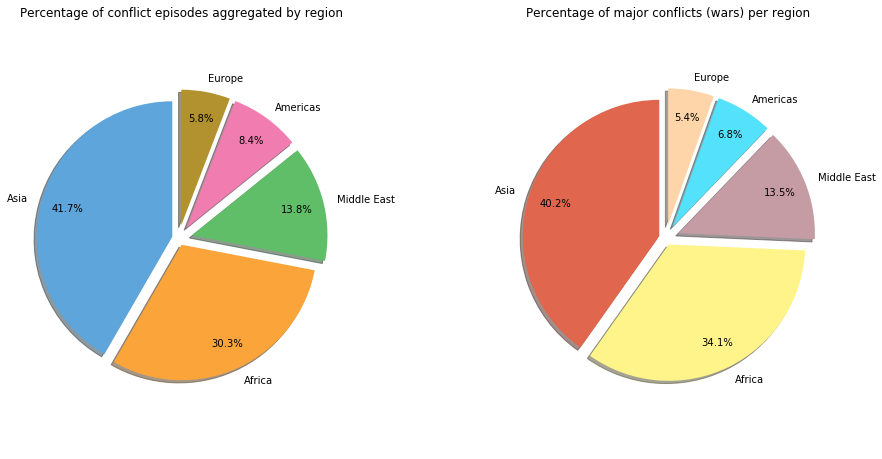

In [37]:
# Pie plot representing the regional distribution of conflict episodes
explode = (0.05, 0.05, 0.1, 0.1, 0.1)
colours1 = ["#5DA5DA", "#FAA43A", "#60BD68", "#F17CB0", "#B2912F"]
colours2 = ["#E0674D", "#FFF48A", "#C59BA4", "#54E1FC", "#FDD5A8"]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 9))
fig.tight_layout()
plt.subplots_adjust(top=0.7, wspace = 0.5)
draw_pie_plot(regional_aggregation[:5].values, list(regional_aggregation[:5].keys()), explode, colours1, "Percentage of conflict episodes aggregated by region", ax[0])
draw_pie_plot(regional_war_count['count'], regional_war_count['region'], explode, colours2, 'Percentage of major conflicts (wars) per region', ax[1])
plt.show()

The above pie charts help visualise the total percentage of conflict episodes and the percentage of war events by region. The plot on the left takes into account the total number of conflict episodes registered in the period 1946-2016, regardless of their intensity, while the pie plot on the right focuses on the major incidents which resulted in more than 1'000 battle-related casualties.

The conclusion that can be drawn, judging by the numbers, is that the number of major incidents contributes almost equally to the total in every World region. There isn't a single region that perhaps had a relatively large share of conflicts, but all or the great majority of them being minor.

The only (barely) noticeable differences, that differ by more than one percent point, are Africa and the Americas. Africa has a larger share of wars than conflicts in general, while it is the opposite for the Americas region. This becomes more obvious from the stacked bar plot below, which shows that the percentage of wars over the total number of conflicts in Africa is 30%, which is larger than any other region where the ratio converges towards one quarter.

In [38]:
temp_total_count = regional_aggregation.reset_index().rename(columns={'region': 'count', 'index': 'region'}).sort_values(by='count', ascending=False)[:5]
regional_war_percentage = regional_war_count[['region', 'count']].merge(temp_total_count, on='region')
regional_war_percentage['war_percentage'] = regional_war_percentage['count_x'] / regional_war_percentage['count_y']
regional_war_percentage['total'] = 1
regional_war_percentage

,region,count_x,count_y,war_percentage,total
0,Asia,244,944,0.258475,1
1,Africa,207,687,0.301310,1
2,Middle East,82,313,0.261981,1
3,Americas,41,190,0.215789,1
4,Europe,33,132,0.250000,1


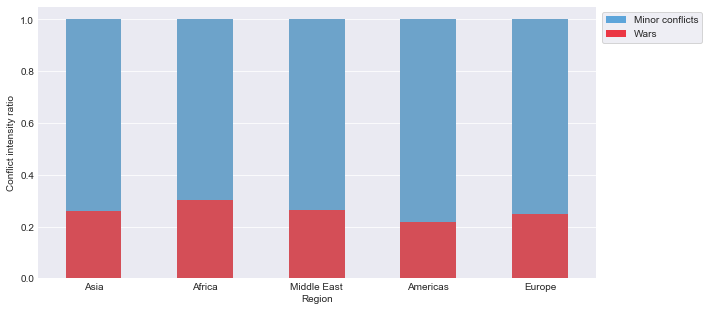

In [39]:
# Set general plot properties
sns.set_style('darkgrid')
sns.set_context({"figure.figsize": (10, 5)})

# Plot 1 - background - "total" (top) series
sns.barplot(x = regional_war_percentage['region'], y = regional_war_percentage['total'], color = "#5DA5DA")

# Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = regional_war_percentage['region'], y = regional_war_percentage['war_percentage'], color = "#EB3744")

# Reduce the width of the bars
for patch in bottom_plot.patches:
    current_width = patch.get_width()
    diff = current_width - 0.5

    # we change the bar width
    patch.set_width(0.5)

    # we recenter the bar
    patch.set_x(patch.get_x() + diff * .5)


# Create legend
topbar = plt.Rectangle((0,0), 1, 1, fc="#EB3744", edgecolor = 'none')
bottombar = plt.Rectangle((0,0), 1, 1, fc='#5DA5DA',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Minor conflicts', 'Wars'], loc=1, ncol = 1, bbox_to_anchor=(1.2, 1))
l.draw_frame(True)

# Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("Conflict intensity ratio")
bottom_plot.set_xlabel("Region")

plt.show()

The plot shows the percentage of armed conflict events that resulted in more than 1'000 deaths opposed to the minor conflicts, aggregated by region. Only the single region events are shown, since the cases of multiregional events are insignificantly small and will only decrease the clarity of the visualisation.

The figure below shows the regional absolute count per intensity level.

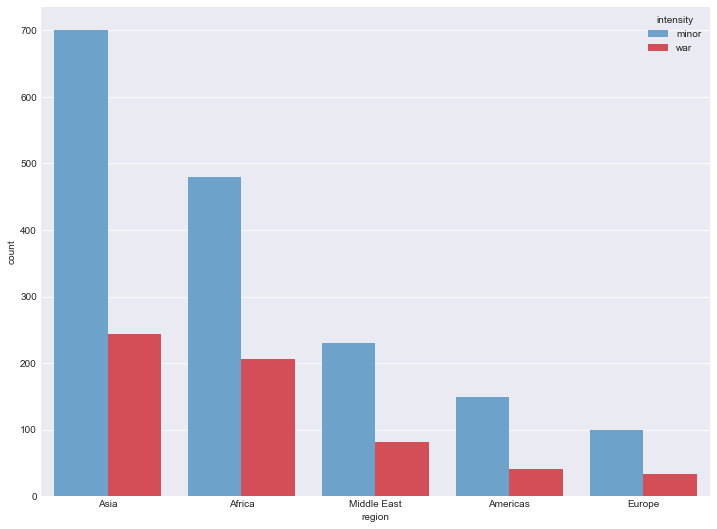

In [40]:
values = region_intensity_aggregated.sort_values(by='count', ascending=False)[:10]

fig, ax = plt.subplots(figsize=(12, 9))
sns.set_style('darkgrid')
ax = sns.barplot(x="region", y='count', hue="intensity", data=values, palette=["#5DA5DA", "#EB3744"])
plt.show()

The above bar plot shows the counts of conflict episodes split according to their severity, based on the UCDP definitions taking into account the number of battle-related deaths, i.e. minor conflicts or wars. Minor conflicts are conflict episodes where the number of deaths is between 25 and 999 (inclusive), whereas for an event to be considered a war the number of casualties must rise above 1'000.

## Conflict episode analysis on a location aggregation basis

In [41]:
# Count the number of conflict events grouped by location and intensity
location_aggregated = armed_conflicts_raw.groupby(by=['location', 'intensity']).size()
location_aggregated = location_aggregated.reset_index()
location_aggregated = location_aggregated.rename(columns={0: 'count'})
location_aggregated.head(10)

,location,intensity,count
0,Afghanistan,minor,4
1,Afghanistan,war,37
2,"Afghanistan, Russia (Soviet Union)",minor,1
3,"Afghanistan, United Kingdom, United States of ...",war,1
4,"Albania, United Kingdom",minor,1
5,Algeria,minor,23
6,Algeria,war,13
7,"Algeria, Morocco",minor,1
8,Angola,minor,24
9,Angola,war,25


There is one subtle issue that needs to be attended to. Namely, there are certain events that have taken place in multiple locations, as is the case with some of the rows visible above: `Afghanistan, Russia (Soviet Union)`; `Albania, United Kingdom`; `Algeria, Morocco`; etc. In order to get a precise count of armed conflict events that happened on the territory of each country, we split the location values to individual countries (separated by a comma) and then add the conflict count to the value of each participant country.

In [42]:
# Split the values of the location column on comma
# Set the columns to keep as indices
temp = pd.DataFrame(location_aggregated['location'].str.split(', ').tolist(), index=[location_aggregated['intensity'], location_aggregated['count']]).stack()
temp = temp.reset_index()[[0, 'intensity', 'count']].rename(columns={0: 'location'})
# Aggregate on the same criterion as before
location_aggregated = temp.groupby(by=['location', 'intensity']).sum().reset_index()
location_aggregated.head()

,location,intensity,count
0,Afghanistan,minor,5
1,Afghanistan,war,38
2,Albania,minor,1
3,Algeria,minor,24
4,Algeria,war,13


In [43]:
country_conflict_count = location_aggregated.groupby(by='location').sum()
country_conflict_top = country_conflict_count.sort_values(by='count', ascending=False).head(20)
country_conflict_top

,count
location,
Myanmar (Burma),271
India,194
Ethiopia,127
Philippines,100
Israel,84
Iraq,73
Colombia,53
Pakistan,52
Indonesia,51


The output represents a list of the top 20 countries on whose territory there were armed conflict episodes during the period 1946-2016, which surpassed the annual minimum of 25 battle-related deaths, regardless of whether it was a minor incident or war. Myanmar (Burma) is without doubt the most prominent country in terms of the number of incidents, but approximately 82% of the conflict episodes resulted in less than 1'000 deaths, therefore they are considered minor conflicts. More on the ratio of minor conflicts vs. wars is presented in the following part.

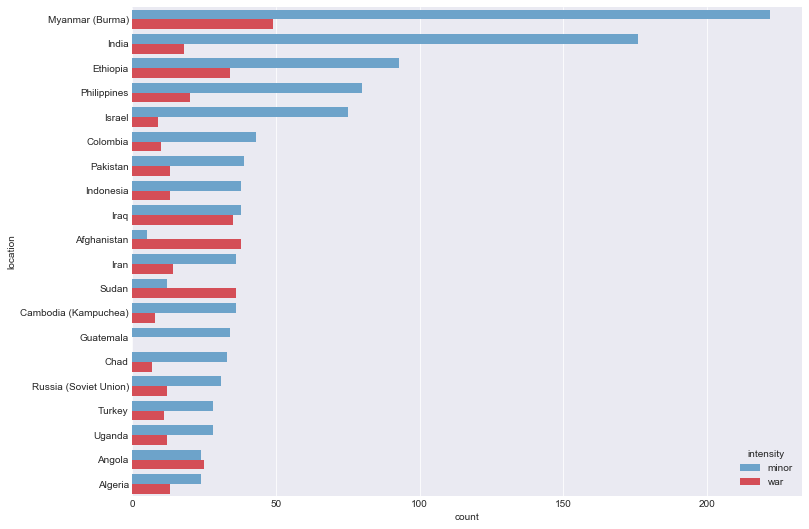

In [44]:
values = location_aggregated[location_aggregated['location'].isin(country_conflict_top.index)]

fig, ax = plt.subplots(figsize=(12, 9))
sns.set_style('darkgrid')
ax = sns.barplot(x="count", y='location', hue="intensity", orient='h', data=values.sort_values(by='count', ascending=False), palette=["#5DA5DA", "#EB3744"])
plt.show()

The figure shows the top 20 locations in the World with the largest number of conflict episode events. The total number is then broken down into two components based on the episode intensity level, namely into minor conflicts and wars. It can be easily seen that Myanmar (Burma) is in the lead, both in the number of minor conflicts and wars on its territory, even though the number of wars is significantly smaller compared to the number of minor conflicts.

It is also worth mentioning that Afghanistan, Sudan and Angola have a higher number of wars than minor incidents in their conflict history, with a percentage as high as 88% for Afghanistan and 75% for Sudan out of the total.

The proportion of war episodes in the total number of conflict events for the top locations is more explicitly presented in the following stacked bar plot figure.

In [45]:
location_war_count = location_aggregated[location_aggregated['intensity'] == 'war']
location_war_count = location_war_count[location_war_count['location'].isin(country_conflict_top.index)][['location', 'count']]

location_war_percentage = location_war_count.merge(country_conflict_top.reset_index(), on='location')
location_war_percentage['war_percentage'] = location_war_percentage['count_x'] / location_war_percentage['count_y']
location_war_percentage['total'] = 1

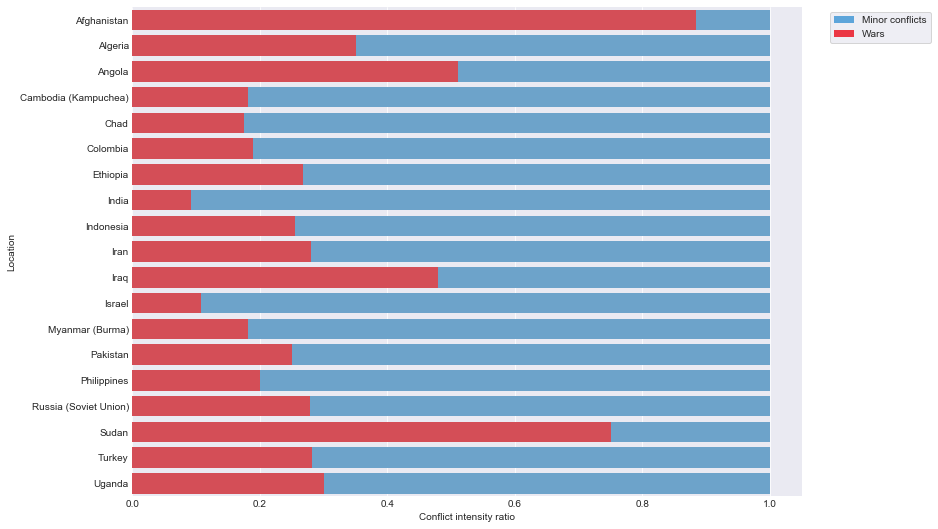

In [46]:
# Set general plot properties
sns.set_style('darkgrid')
sns.set_context({"figure.figsize": (12, 9)})

# Plot 1 - background - "total" (top) series
sns.barplot(y = location_war_percentage['location'], x = location_war_percentage['total'], orient='h', color = "#5DA5DA")

# Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(y = location_war_percentage['location'], x = location_war_percentage['war_percentage'], orient='h', color = "#EB3744")

# Create legend
topbar = plt.Rectangle((0,0), 1, 1, fc="#EB3744", edgecolor = 'none')
bottombar = plt.Rectangle((0,0), 1, 1, fc='#5DA5DA',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Minor conflicts', 'Wars'], loc=1, ncol=1, bbox_to_anchor=(1.2, 1))
l.draw_frame(True)

# Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_xlabel("Conflict intensity ratio")
bottom_plot.set_ylabel("Location")

plt.show()

## Timeline of battle-related deaths

In [47]:
battle_deaths_raw.head(10)

,ConflictID,Year,LocationInc,BdBest,BdLow,BdHigh,BattleLocation
0,13349,2013,Myanmar (Burma),29,29.0,30,Myanmar (Burma)
1,13349,2014,Myanmar (Burma),37,37.0,203,Myanmar (Burma)
2,13349,2015,Myanmar (Burma),106,106.0,181,Myanmar (Burma)
3,13721,2015,Algeria,26,26.0,26,Algeria
4,13692,2001,"Afghanistan, United Kingdom, United States of ...",1490,1482.0,2259,Afghanistan
5,13641,2016,Nigeria,2213,2210.0,2311,Nigeria
6,13641,2015,Nigeria,1919,1916.0,2953,Nigeria
7,11342,2012,India,27,23.0,27,India
8,11342,2014,India,26,23.0,32,India
9,11344,2011,Sudan,145,145.0,145,Sudan


In [48]:
battle_deaths_per_year = battle_deaths_raw.groupby(by='Year')['BdLow', 'BdBest', 'BdHigh'].sum()
battle_deaths_per_year.tail()

,BdLow,BdBest,BdHigh
Year,,,
2012,37569.0,61773,68378
2013,28317.0,90389,100795
2014,101255.0,104755,126452
2015,77109.0,97874,111328
2016,66948.0,87266,98726


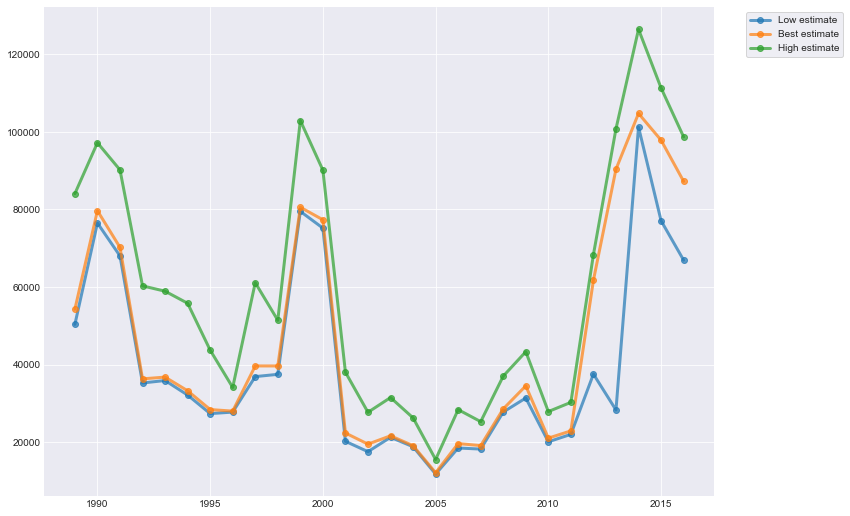

In [49]:
fig, ax = plt.subplots()
sns.set_style('darkgrid')
plt.plot(battle_deaths_per_year, alpha=0.7, linewidth=3, marker='o')

plt.legend(['Low estimate', 'Best estimate', 'High estimate'], loc=1, ncol=1, bbox_to_anchor=(1.2, 1)).draw_frame(True)

plt.show()

There are three very prominent peeks in the shown timeline for the years 1990, 1999 and 2014, where the low and the best estimates which are pretty close to each other indicate approximately 80'000 fatalies for the first two years and go slightly above 100'000 for 2014. If we look at the high estimates, which according to the UCDP methodology of creating the datasets are not an exaggerated, but on the contrary rather conservative figure, the number of battle-related deaths rises well above 120'000 for the year 2014, which is by far the worst year in terms of casualties for the given period between 1989-2016. The available data shows a decreasing tendency after that, but since there are only two more years after 2014, it is impossible to precisely determine the trend. Even though the slope of the line is large, the absolute value of the figures is among the largest. 

## Conflict graph

One of the major points of this project is producing a network diagram visualising a graph structure of interconnected nodes which represent conflicted sides based on the UCDP Georeferenced Event Dataset (GED) Global version 17.1 data. The following section will produce two separate network plots for improved clarity of the visualisation: state-based and non-state conflict graph. The former represents the conflicts where at least one party is a government, whereas the latter depicts relations between organised groups where no government was involved on either side. Also, in order to keep the plots as simple as possible, only the primary actors in a conflict were included, i.e. the graph doesn't include supporters or allies who fought together with the primary actors. Both graphs cover the time period between 1989-2016.

### Data preparation

In [50]:
# Filter out only the state-based conflicts (where at least one side is a government)
conflict_graph_raw = ged_global_raw[ged_global_raw['type_of_violence'] == 'state-based']
# Filter out the non-state conflicts that have organised groups as actors, no government involved
conflict_graph_nonstate_raw = ged_global_raw[ged_global_raw['type_of_violence'] == 'non-state']

# Project only the columns of interest for the conflict graph
columns_of_interest = ['conflict_new_id', 'side_a_new_id', 'side_b_new_id', 'deaths_a', 'deaths_b', 
                       'deaths_civilians', 'deaths_unknown', 'best', 'low', 'high']
conflict_graph_raw = conflict_graph_raw[columns_of_interest]
conflict_graph_nonstate_raw = conflict_graph_nonstate_raw[columns_of_interest]

A useful information to include in the plot is the intensity of the conflict, i.e. whether it was a minor conflict with a number of suffered casualties that ranged between 25 and 1'000 for the entire period the conflict was active or a war, which means the number of battle-related deaths surpassed 1'000. However, this data is not present in the Georeferenced Event Dataset (GED), but it is available in the Armed Conflict Dataset, with a slight additional processing in order to get conflict aggregated data.

Of course, it is interesting to obtain the cumulative conflict intensity taking into account the entire period the conflict was active and not just individual episodes or annual aggregates. However, the cumulative conflict intensity field in the Armed Conflict dataset provides this information chronologically, up until a particular year and once a conflict matches the criteria to be upgraded into war, it does not retroactively update the `cumint` field values. Therefore, what we do is if there is at least a <b>single</b> entry for a particular conflict which indicates that its cumulative intensity is war, then the final conflict intensity will be war. For minor conflicts, if <b>all</b> of the cumulative intensity values indicate minor conflict, then the final intensity will be minor conflict.

<u>Note</u>: the Armed Conflict dataset only contains information about the conflicts where at least one of the sides is the government of a country, i.e. only for the state-based conflict types.

In [186]:
# If any year was marked as a war, then the entire conflict should be considered as war
# Technically, if war=1 and minor=0, then take the maximum for each conflict
conflict_intensity = armed_conflicts_raw[['conflictid', 'cumint']].copy()
conflict_intensity.loc[conflict_intensity['cumint'] == 'war', 'cumint'] = 1
conflict_intensity.loc[conflict_intensity['cumint'] == 'minor', 'cumint'] = 0
conflict_intensity = conflict_intensity.groupby(by='conflictid').max()
conflict_intensity.loc[conflict_intensity['cumint'] == 1, 'cumint'] = 'war'
conflict_intensity.loc[conflict_intensity['cumint'] == 0, 'cumint'] = 'minor'

Unlike the Armed Conflict Dataset, the Non-state Conflict Dataset does not come with a dummy variable indicated the cumulative intensity of the conflict between the two conflicted parties. Therefore, it needs to be computed based on the criteria stated in the datasets documentation and also above. The decision will be based on the best estimate measure of battle-related deaths, since that is both a more conservative and precise number.

In [189]:
nonstate_conflict_intensity = nonstate_conflicts_raw[['conflictid', 'fatbest']].groupby(by='conflictid').sum()
nonstate_conflict_intensity['cumint'] = nonstate_conflict_intensity.apply(lambda row: 'war' if row['fatbest'] >= 1000 else 'minor', axis=1)
nonstate_conflict_intensity = nonstate_conflict_intensity[['cumint']]

Group all the individual conflict episodes based on the conflict they belong to. Each conflict has the same side A and side B actors, so grouping by them as well makes them available in the result.

In [55]:
column_groups = ['conflict_new_id', 'side_a_new_id', 'side_b_new_id']
conflict_graph_df = conflict_graph_raw.groupby(column_groups).sum().reset_index()
# Add the cumulative conflict intensity information
conflict_graph_df = conflict_graph_df.merge(conflict_intensity, how='inner', left_on='conflict_new_id', right_index=True)

conflict_graph_nonstate_df = conflict_graph_nonstate_raw.groupby(column_groups).sum().reset_index()
# Add the cumulative conflict intensity information
conflict_graph_nonstate_df = conflict_graph_nonstate_df.merge(nonstate_conflict_intensity, how='inner', left_on='conflict_new_id', right_index=True)

In [58]:
column_rename_dict = {
    'Name_x': 'side_a_name',
    'NameFull_x': 'side_a_name_full',
    'Name_y': 'side_b_name',
    'NameFull_y': 'side_b_name_full'
}

# Resolve the names for the state-based conflicts
conflict_graph_df = conflict_graph_df.merge(actor_list_raw, how='inner', left_on='side_a_new_id', right_index=True)
conflict_graph_df = conflict_graph_df.merge(actor_list_raw, how='inner', left_on='side_b_new_id', right_index=True)
conflict_graph_df = conflict_graph_df.rename(columns=column_rename_dict)

# Resolve the names for the non-state conflicts
conflict_graph_nonstate_df = conflict_graph_nonstate_df.merge(actor_list_raw, how='inner', left_on='side_a_new_id', right_index=True)
conflict_graph_nonstate_df = conflict_graph_nonstate_df.merge(actor_list_raw, how='inner', left_on='side_b_new_id', right_index=True)
conflict_graph_nonstate_df = conflict_graph_nonstate_df.rename(columns=column_rename_dict)

In [59]:
conflict_graph_df.head()

,conflict_new_id,side_a_new_id,side_b_new_id,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,low,high,cumint,side_a_name,side_a_name_full,side_b_name,side_b_name_full
0,205,114,164,22,48,92,56,218,218,543,war,Government of Iran,Government of Iran,KDPI,Republic of Kurdistan
160,338,114,308,41,179,7,144,371,371,534,war,Government of Iran,Government of Iran,MEK,People's Mujahideen
161,338,114,309,157,310,16,11,494,489,794,war,Government of Iran,Government of Iran,PJAK,The Free Life Party of Kurdistan
162,338,114,310,113,47,27,109,296,280,392,war,Government of Iran,Government of Iran,Jondullah,God’s Army
1,209,154,169,3084,4133,231,216,7664,7613,10335,war,Government of Philippines,Government of Philippines,CPP,Communist Party of the Philippines


In [60]:
conflict_graph_nonstate_df.head()

,conflict_new_id,side_a_new_id,side_b_new_id,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,low,high,cumint,side_a_name,side_a_name_full,side_b_name,side_b_name_full
0,4564,783,234,5,3,0,17,25,25,25,minor,1920 Revolution Brigades,1920 Revolution Brigades,IS,The Monotheism and Jihad Group
520,13325,366,234,8,25,4,47,84,84,125,minor,Hezbollah,Party of God,IS,The Monotheism and Jihad Group
507,12997,1130,234,0,1,0,0,1,1,1,minor,FSA,Free Syrian Army,IS,The Monotheism and Jihad Group
549,13695,5802,234,168,175,28,64,435,429,520,minor,Forces of the House of Representatives,Libyan National Army,IS,The Monotheism and Jihad Group
550,13705,6371,234,49,105,11,33,198,187,204,minor,Derna Mujahideen Shura Council,Derna Mujahideen Shura Council,IS,The Monotheism and Jihad Group


### Conflict graph construction

A node in the graph corresponds to a single actor in a conflict, which might be a government of a country or an organised group of any type. The nodes themselves are identified by the id of the actor: `side_a_new_id` or `side_b_new_id`. In addition to that, the attributes that are saved in the node are the name or the acronym (with the full name in enclosed in parentheses) and the number of suffered casualties for each side.

An edge indicates an existent conflict between the sides represented by the two nodes. They store information about the cumulative intensity of the conflict (`cumint`).

The information stored as attributes will be useful in the further processing, in particular the drawing of the network plot itself.

In [61]:
def create_graph_structure(df, node_set_a='side_a_new_id', node_set_b='side_b_new_id'):
    '''
    Create the network structure based on the data passed in as first parameter
    '''
    # Create the graph object
    G = nx.Graph()
    
    # Add the nodes and the edges from the dataframe - duplicate IDs don't cause the creation of a new node
    G.add_nodes_from(df[node_set_a], deaths=0)
    G.add_nodes_from(df[node_set_b], deaths=0)
    G.add_edges_from(list(zip(df[node_set_a], df[node_set_b])), intensity='')
    
    # Add attributes to the nodes and edges
    for row_tuple in df.iterrows():
        row = row_tuple[1]
        node_a = row['side_a_new_id']
        node_b = row['side_b_new_id']

        # If the name is an acronym, enclose the full name in parentheses
        # Names which are not acronyms are repeated in both columns
        side_a_name = row['side_a_name']
        if row['side_a_name'] != row['side_a_name_full']:
            side_a_name += ' (' + row['side_a_name_full'] + ')'

        side_b_name = row['side_b_name']
        if row['side_b_name'] != row['side_b_name_full']:
            side_b_name += ' (' + row['side_b_name_full'] + ')'

        G.nodes[node_a]['node_name'] = side_a_name
        G.nodes[node_b]['node_name'] = side_b_name
        G.nodes[node_a]['deaths'] += row['deaths_a']
        G.nodes[node_b]['deaths'] += row['deaths_b']

        G.edges[node_a, node_b]['intensity'] = row['cumint']
        
    # Compute the positions of each node in order to plot it
    positions = nx.spring_layout(G, k=0.10, iterations=50)

    # Make the position value a node attribute
    for pos in positions:
        G.node[pos]['position'] = positions[pos]
        
    return G

In [62]:
def create_node_trace(legend_title, line_color, colorscale, mode='markers', reversescale=True, font_size=14, symbol='circle', marker_opacity=0.9, line_width=2):
    '''
    Create the points that match the nodes in the graph and set the corresponding attributes
    '''
    node_trace = Scatter(
        x = [],  # Sets the x coordinates
        y = [],  # Sets the y coordinates
        text = [],  # Sets text elements associated with each (x,y) pair. If an array, the items are mapped to the (x,y) coordinates.
        mode = mode,
        hoverinfo = 'text',  # Determines which trace information appears on hover
        textposition = 'middle center',  # Sets the positions of the `text` elements with respects to the (x,y) coordinates
        hoverlabel = dict(
            font = dict(
                size = font_size,
            )
        ),
        marker = Marker(
            symbol = symbol,  # Sets the marker symbol type
            opacity = marker_opacity,
            showscale = True,  # Determines whether or not a colorbar is displayed
            colorscale = colorscale,
            reversescale = reversescale,
            color = [],  # Colorbar is valid only if the color array is numerical
            size = [],  # Sets the marker size (in px)
            colorbar = dict(
                thickness = 20,  # Sets the thickness of the color bar excluding the size of the padding, ticks and labels.
                title = legend_title,
                xanchor = 'left',  # Sets this color bar's horizontal position anchor
                yanchor = 'middle',  # Sets this color bar's vertical position anchor
                titleside = 'right'
            ),
            line = dict(
                width = line_width,  # Sets the width (in px) of the lines bounding the marker points
                color = line_color  # Sets the marker.line color
            )
        )
    )
    
    return node_trace


def create_edge_trace(color, line_width=2, opacity=0.8):
    '''
    Create the lines that match the edges in the graph and set the corresponding attributes
    '''
    edge_trace = Scatter(
        x = [],
        y = [],
        text = [],
        opacity = opacity,
        hoverinfo = 'none',
        line = Line(
            width = line_width,
            color = color
        ),
        mode = 'lines'
    )
    
    return edge_trace


def set_node_points(G, node_trace, min_threshold=6, min_size=10, max_size=30):
    '''
    Set the drawing parameters for the nodes
    @param min_threshold: Points whose representation needs to be scaled up for better visibility
    @param min_size: The minimal size of a point in the graph in order to be well visible
    @param max_size: The maximal size of a point in the graph
    '''
    for idx, node in enumerate(G.nodes()):
        x, y = G.node[node]['position']
        node_trace['x'].append(x)
        node_trace['y'].append(y)
        # Set the text that appears when hovering over the node
        label = "<b>" + G.node[node]['node_name'] + "</b>" + "<br>Casualties: " + str(G.node[node]['deaths']) + "<br>Number of conflicts: " + str(G.degree[node])
        node_trace['text'].append(label)

        # Set the node size to be proportional to the number of conflicts the matching side is involved in
        if G.degree[node] <= min_threshold:
            node_trace['marker']['size'].append(min_size)
        else:
            node_trace['marker']['size'].append(min(G.degree[node] * 1.5, max_size))

        # Set the colour to correspond to the number of deaths suffered by that side
        node_trace['marker']['color'].append(G.node[node]['deaths'])
        
    return node_trace


def set_edge_points(G, edge_trace, intensity_level):
    '''
    Set the drawing parameters for the edges
    @param intensity_level: The group to which the trace belongs to
    '''
    for idx, edge in enumerate(G.edges()):
        x0, y0 = G.node[edge[0]]['position']
        x1, y1 = G.node[edge[1]]['position']
        intensity = G.edges[edge]['intensity']
        
        if intensity == intensity_level:
            edge_trace['x'] += [x0, x1, None]
            edge_trace['y'] += [y0, y1, None]
        
    return edge_trace


def draw_figure(data, title, background_color, width=1000, height=800, font_size=16):
    '''
    Create the figure for the graph's network plot
    '''
    figure = Figure(
        data = data,
        layout = Layout(
            autosize = False,
            width = width,
            height = height,
            title = title,
            titlefont = dict(
                size = font_size
            ),
            showlegend = False,
            plot_bgcolor = background_color,
            hovermode = 'closest',
            margin = dict(
                b = 20, 
                l = 5, 
                r = 5, 
                t = 60
            ),
            xaxis = XAxis(showgrid=False, zeroline=False, showticklabels=False),
            yaxis = YAxis(showgrid=False, zeroline=False, showticklabels=False)
        )
    )
    
    return figure

In [209]:
def draw_network_plot(G, figure_title):
    '''
    Create the constituent elements of the graph's network plot
    '''
    node_trace = create_node_trace('Suffered casualties', 'rgba(0, 0, 0, 0.2)', 'YlOrRd')
    edge_trace_war = create_edge_trace('rgba(0.25, 0.45, 0.85, 1)')  # darker nuance for war conflicts
    edge_trace_minor = create_edge_trace('rgba(0.55, 0.85, 0.95, 1)')  # lighter nuance for war conflicts


    node_trace = set_node_points(G, node_trace)
    # Create different edge plots based on the intensity level in order to have different line colours for each
    edge_trace_war = set_edge_points(G, edge_trace_war, 'war')
    edge_trace_minor = set_edge_points(G, edge_trace_minor, 'minor')

    figure = draw_figure(Data([edge_trace_war, edge_trace_minor, node_trace]), figure_title, '#EFECEA')
    
    return G, figure

In [64]:
G = create_graph_structure(conflict_graph_df)
state_based_figure_title = '<br><b>State-based conflict graph</b>'
state_based_conflict_graph, state_based_conflict_plot = draw_network_plot(G, state_based_figure_title)

In [215]:
py.offline.iplot(state_based_conflict_plot, filename='state-based-conflict-graph.html')

<i>In case the figure does not display properly, please follow this link: https://vjan-fin.github.io./resources/state-based-conflict-graph.html.</i>

The above graph visualisation depicts the state-based conflict interactions between actors where at least one of the sides is a government of a state and the opposing side can be a government as well or an organised group (formally or informally organised).

Each node in the plot is depicted by a circle and represents a single actor as defined in the UCDP Actor list dataset. Interactions between actors exist if there is a record of a conflict between them in the period 1989-2016. A conflict interaction is represented by a line going from one node to the other, i.e. an undirected edge between the two nodes corresponding to the involved actors. The edges are colour-coded for the conflict intensity. More specifically, minor conflicts which count between 25 and 1'000 battle-related deaths are shown by <i>light blue</i>, whereas major conflicts or wars which surpass the 1'000 casualties limit are shown in a <i>dark blue</i> colour.

The size of each node in the plot depends on what is technically called the degree of that node. Simply stated, the degree of the node is the number of conflicts the corresponding actor has been involved in during the given time period. In addition, the colour of each node gives an intuition on the number of casualties due to battles each side has suffered, ranging from light yellow when the numbers are small, to dark red nuances as the number of deaths grows.

The plot is interactive. Hovering over a node shows a label with the name and with more detailed information about the entity. There is also a possibility to pan around, zoom in and out on the entire plot or a selected region to analyse it in more detail.

In [66]:
# Simple graph analysis
print("Number of nodes: %d" % state_based_conflict_graph.number_of_nodes())
print("Number of edges: %d\n" % state_based_conflict_graph.number_of_edges())

degrees = [degree for node, degree in state_based_conflict_graph.degree()]
print("Minimum degree: %d" % min(degrees))
print("Maximum degree: %d\n" % max(degrees))

connected_components = list(nx.connected_components(state_based_conflict_graph))
largest_component_state_conflicts = max(nx.connected_component_subgraphs(state_based_conflict_graph), key=len)
print("Number of distinct connected components: %d" % len(connected_components))
print("Number of nodes in the largest connected component: %d" % largest_component_state_conflicts.number_of_nodes())
print("Number of edges in the largest connected component: %d\n" % largest_component_state_conflicts.number_of_edges())

Number of nodes: 405
Number of edges: 355

Minimum degree: 1
Maximum degree: 24

Number of distinct connected components: 55
Number of nodes in the largest connected component: 140
Number of edges in the largest connected component: 142



The total number of actors is 405 and they were involved in 355 state-based conflicts. Of course, the minimum number of conflicts a side can be involved in is 1, otherwise it would not have been depicted in the figure. The largest number of conflicts a single side has been involved in is 24. 

A connected component is a subgraph in which there is a path between any two arbitrary nodes. The interpretation of a connected component for the underlying problem is a group of actors which are connected either by mutual enemies or a list of intermediary actors.

The analysis and the comparison of the two produced graphs follows below.

In [67]:
G = create_graph_structure(conflict_graph_nonstate_df)
nonstate_based_figure_title = '<br><b>Non-state conflict graph</b>'
nonstate_based_conflict_graph, nonstate_based_conflict_plot = draw_network_plot(G, nonstate_based_figure_title)

In [223]:
py.offline.iplot(nonstate_based_conflict_plot, filename='non-state-conflict-graph.html')

<i>In case the figure does not display properly, please follow this link: https://vjan-fin.github.io./resources/non-state-conflict-graph.html.</i>

The above graph visualisation depicts the non-state conflict interactions between actors where there is no government of a state involved. The opposing sides are different types of organised groups (formally or informally organised).

All the other details perfectly match the description provided above.

It is interesting to notice, contrary to the state-based conflicts, there are hardly any wars in the non-state conflicts.

In [69]:
# Simple graph analysis
print("Number of nodes: %d" % nonstate_based_conflict_graph.number_of_nodes())
print("Number of edges: %d\n" % nonstate_based_conflict_graph.number_of_edges())

degrees = [degree for node, degree in nonstate_based_conflict_graph.degree()]
print("Minimum degree: %d" % min(degrees))
print("Maximum degree: %d\n" % max(degrees))

connected_components = list(nx.connected_components(nonstate_based_conflict_graph))
largest_component_nonstate_conflicts = max(nx.connected_component_subgraphs(nonstate_based_conflict_graph), key=len)
print("Number of distinct connected components: %d" % len(connected_components))
print("Number of nodes in the largest connected component: %d" % largest_component_nonstate_conflicts.number_of_nodes())
print("Number of edges in the largest connected component: %d\n" % largest_component_nonstate_conflicts.number_of_edges())

Number of nodes: 761
Number of edges: 575

Minimum degree: 1
Maximum degree: 18

Number of distinct connected components: 221
Number of nodes in the largest connected component: 42
Number of edges in the largest connected component: 53



The total number of actors is 761 and they were involved in 575 non-state conflicts. Of course, the minimum number of conflicts a side can be involved in is 1, otherwise it would not have been depicted in the figure. The largest number of conflicts a single side has been involved in is 18.

As perhaps expected, the number of nodes in the non-state conflict graph is noticeably greater than the number of nodes in the case when one of the conflicted sides is the Government of a state. Of course, there is no limitation to the number of organisations that can be formed and that can enter a conflict for some reason and over a certain disagreement. Also, organisations are much more dynamic in their creation and cease of existence, whereas for states it is a much longer and slower process that can take decades or even centuries. In addition, the latter graph is much richer in the number of edges, i.e. the interactions between the parties, but it is also evident that, though more numerous, the interactions are in the vast majority of less gravity as they are considered `minor conflicts` according to the UCDP criteria.

The bigger number of war conflicts together with the much smaller number of connected components in the state-based conflict graph compared to the non-state graph is a clear indication that conflicts which involve a government as a conflicted side tend to have larger dimensions, they are not localised, but involve many other organisations and states. Much of it results from the fact that states have significantly more resources and a more organised way of warfare. Also, they are usually the primary target of many organisations. As an additional point, countries have international relations and interests which are global, whereas the activities of organised groups usually have a much more limited target, concern only a particular region or population group based on certain characteristics, etc.

Here we cannot use the argument that states have a larger number of conflicts and battle-related deaths due to their longer history as all the numbers are related to the time period between 1989 and 2016. However, one can argue that this is a sufficiently large time period for an organised group to form, reform, merge with other groups, form fractions, rename, cease to exist, etc., which breaks the continuity when analysing its activity. It is very difficult to differentiate whether the organised group should be considered the same or whether the conflict is the same once some of the previously mentioned events occur. As stated in the previous paragraph, clashes between organised groups are much smaller in magnitude, which is easily observed by the number of suffered casualties on each side.

In [70]:
component_figure_title = '<br><b>Zoom-in on the state-based conflict graph</b>'
component_conflict_graph, component_conflict_plot = draw_network_plot(largest_component_state_conflicts, component_figure_title)

In [221]:
py.offline.iplot(component_conflict_plot, filename='zoom-in-state-conflict-graph.html')

<i>In case the figure does not display properly, please follow this link: https://vjan-fin.github.io./resources/zoom-in-state-conflict-graph.html.</i>

The above plot simply zooms-in on the largest connected component of the state-based conflict graph. It is remarkable that at the centre of this component is the node representation of IS (Islamic State), something that is very current and actual. The figure shows the 34'830 casualties that IS has suffered during the 15 conflicts it is involved in, mostly with countries from the Middle East and North Africa.

## Battle locations map

Another informative visualisation which implies taking advantage of the fine-grained geo-coding information available in the UCDP Georeferenced Event Dataset is creating an interactive map with markers pinpointing the geographical locations where there was an armed conflict episode in the period 1989-2016. However, the dataset consists of 135'181 distinct conflict episodes, 38'657 of which are unique battles that took part on a particular location during a conflict. Therefore, there are 38'657 unique (conflict, location) tuples which potentially need to be represented on the map. Even with the marker clustering, this is a huge number of points on the map. In order to reduce the crowdedness, but also to avoid being exposed to the limitations of the map plot library which is not able to handle such a huge load, it was decided to take the largest battle from every conflict and depict it on the interactive map. The "largest" battle is defined as the one that resulted in the largest number of casualties according to the best estimate. This produces 997 pins, which is more feasible and clearer to analyse.

A second interactive map then shows the 200 largest battle locations (according to the definition stated above) not aggregated by conflict.

In [1542]:
# Indicate the columns that need to be considered
aggregation_columns = ['conflict_new_id', 'latitude', 'longitude', 'conflict_name',
                       'type_of_violence', 'side_a_new_id', 'side_b_new_id', 'country', 'region']

ged_location_aggregated = ged_global_raw.groupby(by=aggregation_columns).agg({
    'year': [np.min, np.max],
    'deaths_a': np.sum, 
    'deaths_b': np.sum, 
    'deaths_civilians': np.sum,
    'deaths_unknown': np.sum,
    'low': np.sum,
    'best': np.sum,
    'high': np.sum
}).reset_index()

In [1543]:
ged_location_aggregated.shape

(38657, 18)

In [1544]:
ged_location_aggregated.columns = ged_location_aggregated.columns.get_level_values(0)
ged_location_aggregated.columns.values[9] = 'min_year'
ged_location_aggregated.columns.values[10] = 'max_year'

In [1545]:
# Resolve the names of each actor in the conflict based on their IDs
ged_location_aggregated = ged_location_aggregated.merge(actor_list_raw, how='inner', left_on='side_a_new_id', right_index=True)
ged_location_aggregated = ged_location_aggregated.merge(actor_list_raw, how='inner', left_on='side_b_new_id', right_index=True)
ged_location_aggregated = ged_location_aggregated.rename(columns=column_rename_dict)

In [1546]:
ged_location_aggregated.head()

,conflict_new_id,latitude,longitude,conflict_name,type_of_violence,side_a_new_id,side_b_new_id,country,region,min_year,...,deaths_b,deaths_civilians,deaths_unknown,low,best,high,side_a_name,side_a_name_full,side_b_name,side_b_name_full
0,205,32.000000,53.000000,Iran:Kurdistan,state-based,114,164,Iran,Middle East,1995,...,2,0,0,2,2,13,Government of Iran,Government of Iran,KDPI,Republic of Kurdistan
1,205,33.000000,44.000000,Iran:Kurdistan,state-based,114,164,Iraq,Middle East,1993,...,5,1,5,11,11,11,Government of Iran,Government of Iran,KDPI,Republic of Kurdistan
2,205,33.340582,44.400876,Iran:Kurdistan,state-based,114,164,Iraq,Middle East,1994,...,1,0,0,1,1,1,Government of Iran,Government of Iran,KDPI,Republic of Kurdistan
3,205,34.102554,45.508912,Iran:Kurdistan,state-based,114,164,Iran,Middle East,1993,...,4,6,1,11,11,11,Government of Iran,Government of Iran,KDPI,Republic of Kurdistan
4,205,34.806667,46.488611,Iran:Kurdistan,state-based,114,164,Iran,Middle East,1990,...,0,0,18,18,18,22,Government of Iran,Government of Iran,KDPI,Republic of Kurdistan


In [1559]:
# Generate the appearence of the battle card that is displayed on-click of the marker

def generate_side_table(side_id, name, full_name, deaths):
    '''
    Generate the HTML template code for the side-specific information
    '''
    side_template = "<b>Side %s: %s" % (side_id, name.replace("'", r"\'"))
    if name != full_name:
        side_template += " (%s)" % full_name.replace("'", r"\'")
    side_template += "</b>"
    side_table = """<table style="width:100%">
        <tr>
            <td>Suffered casualties:</td>
            <td>""" + str(deaths) + """</td>
        </tr>
    </table>"""
    
    return side_template + side_table


def generate_label(row):
    '''
    Generate the HTML template for the battle card window
    '''
    title = '<h5>%s</h5><hr>' % (row['conflict_name'].replace("'", r"\'"))
    
    period = '<b>Time period:</b> %d' % (row['min_year'])
    if row['min_year'] != row['max_year']:
        period += "-%d" % row['max_year']
#     period += '</b>'
    
    body = """<table style="width:100%">
        <tr>
            <td>Best estimate on the casualties:&emsp;</td>
            <td>""" + str(row['best']) + """</td>
        </tr>
        <tr>
            <td>Low estimate on the casualties:&emsp;</td>
            <td>""" + str(row['low']) + """</td>
        </tr>
        <tr>
            <td>High estimate on the casualties:&emsp;</td>
            <td>""" + str(row['high']) + """</td>
        </tr>
        <tr>
            <td>Civilian casualties:</td>
            <td>""" + str(row['deaths_civilians']) + """</td>
        </tr>
        <tr>
            <td>Other casualties:</td>
            <td>""" + str(row['deaths_unknown']) + """</td>
        </tr>
        <tr>
            <td>&nbsp;</td>
            <td>&nbsp;</td>
        </tr>
        <tr>
            <td>Battle location:</td>
            <td>""" + str(row['country']) + """</td>
        </tr>
        <tr>
            <td>Battle region:</td>
            <td>""" + str(row['region']) + """</td>
        </tr>
        <tr>
            <td>Type of violence:</td>
            <td>""" + str(row['type_of_violence']) + """</td>
        </tr>
    </table>"""
    
    side_a_template = generate_side_table("A", row['side_a_name'], row['side_a_name_full'], row['deaths_a'])
    side_b_template = generate_side_table("B", row['side_b_name'], row['side_b_name_full'], row['deaths_b'])
    
    html_template = title + period + "<br><br>" + body + "<br>" + side_a_template + "<br>" + side_b_template
    
    return html_template

In [1561]:
# Generate a new map object
battle_map = folium.Map(location=[20, 0], tiles="Mapbox Bright", zoom_start=2, world_copy_jump=True, no_wrap=False)
# Cluster the markers for every zoom level as there are too many and may cause the map to become crowded otherwise
marker_cluster = MarkerCluster().add_to(battle_map)
conflict_ids = list(set(ged_location_aggregated['conflict_new_id']))

# Choose the battle which has the largest number of suffered casualties according to the best estimate, per conflict
for conflict_id in conflict_ids:
    max_best_deaths_ind = ged_location_aggregated[ged_location_aggregated['conflict_new_id'] == conflict_id]['best'].idxmax()
    max_best_row = ged_location_aggregated.iloc[max_best_deaths_ind]
    
    label = generate_label(max_best_row)
    
    # Create a clickable marker pinpointing the battle location
    folium.Marker(
        location=[max_best_row['latitude'], max_best_row['longitude']],
        popup=label,
        icon=folium.Icon(color='red', icon_color='white', icon='male', prefix='fa'),
    ).add_to(marker_cluster)
    
battle_map.save('battle-map.html')

<i>Since the map could not be properly displayed, please follow this link: https://vjan-fin.github.io./resources/battle-map.html.</i>

In [1562]:
# Generate a new map object
biggest_conflicts_map = folium.Map(location=[20, 0], tiles="Mapbox Bright", zoom_start=2, world_copy_jump=True, no_wrap=False)
# Cluster the markers for every zoom level as there are too many and may cause the map to become crowded otherwise
marker_cluster_top = MarkerCluster().add_to(biggest_conflicts_map)
top_conflicts = ged_location_aggregated.sort_values(by='best', axis=0, ascending=False).head(200)

for row_tuple in top_conflicts.iterrows():
    row = row_tuple[1]
    
    label = generate_label(row)
    
    # Create a clickable marker pinpointing the battle location
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=label,
        icon=folium.Icon(color='red', icon_color='white', icon='male', prefix='fa'),
    ).add_to(marker_cluster_top)
    
biggest_conflicts_map.save('biggest-battles-map.html')
biggest_conflicts_map

<i>Since the map most probably could not be properly displayed, please follow this link: https://vjan-fin.github.io./resources/biggest-battles-map.html.</i>

The styling of the maps is intentionally chosen to include only the smallest level of details and the most necessary information in order to ensure focus on the markers and the goal of the map, which is to present the battle locations for different conflicts on the World map. To improve visibility and omit unnecessary information and crowding on a smaller zoom level, the markers are grouped into clusters. Using the `plus` and `minus` signs on the map (or any other way to control the zoom level) will reveal the individual locations of a battle.

The map is interactive, which means the markers can be clicked on. Hovering over a cluster of markers highlights a polygon area on the map indicating the positions of the markers it is grouping. The colour of the circle indicating a marker cluster ranges from green to orange/red as the number of markers in the group is growing. Clicking on a cluster of markers automatically zooms in and shows smaller clusters or individual markers. Clicking on an individual marker displays the so-called <b>battle card</b> with useful information about each battle. The contents of each card is self-explanatory.

## Internal conflict index map

Some of the research questions we stated in the project proposal were the following:

* Identify "problematic" regions on the World map with recent or on-going conflicts
* Rate regions by safety based on the history of conflicts they were involved in and their respective magnitude:
  * number of conflicts
  * time since last conflict
  * number of casualties
  * gravity of the conflicts
  
In order to rate the countries, we need to have a kind of quantitative measure used for comparison. One way of expressing the internal and external conflict state of a country numerically is to use the Global Peace Index (GPI) measure. Nevertheless, GPI actually uses UCDP datasets such as UCDP Armed Conflict Dataset and UCDP Battle-related Deaths Dataset. Of course, this is a well established methodology, but requires many more additional sources of data, which means it will not be representative of the datasets we have in hand. Therefore, we will develop a strategy of computing a so-called `internal conflict index` which will give a rough idea of where each country stands in terms of internal peace on the global scale.

It is important to mention that the `internal conflict index` is a simple way to combine all the values available for a country. It is not a scientific measure, it does not follow an established and prooven methodology, nor the weights have been derived or determined by domain experts. What we need is a means to visualise countries on the map relative to one another, taking into respect the meaningful data available from the datasets used in this project.

### Computing the index

In [81]:
def max_min_normalisation(data, col_name):
    '''
    Apply max-min normalisation in order to map values to the range [0,1]
    '''
    col = data[col_name]
    return (col - min(col)) / (max(col) - min(col))

<b>Intensity weight:</b> The cumulative intensity of a conflict is converted into a weighting factor where wars are weighted by a factor of 1 and minor conflicts by 0.3, due to a relative difference in gravity. This weight is then used as a factor in an attempt to say that a country recuperates from a minor conflict more easily, but it takes a lot longer after a major conflict.

<b>Duration:</b> The year span between the dates of the first and the last record of a conflict episode. The value is max-min normalised to be in the range [0,1].

<b>Weighted deaths:</b> In order to take into account all the different provided death estimates, a weighted average is performed, such that the best estimate is given a weight of 0.5 and the low and high account for 0.25 each. The value is max-min normalised to be in the range [0,1].

<b>Years since:</b> The number of years between the last record of a conflict episode and 2016 (which is the last available year in the dataset, so it will be considered as the current year). Contrary to `duration` and `weighted_deaths`, the lower the value of `years_since` the worse. Therefore, this variable is included in the equation as $ 1 - years\_since $. The value is max-min normalised to be in the range [0,1].

<b>Conflict grade:</b> A single numeric value that summarises the above-mentioned attributes and gives a grade of the severity of a conflict. The equation for computing it is given below. The lower the value, the less serious the conflict is.

$$ conflict\_grade = intensity\_weight \times (1 + duration - years\_since + weighted\_deaths) $$

In [85]:
# This is the final year data is available for, so it will be considered as the current year
lastYear = 2016

conflict_territories = ged_global_raw[['country', 'conflict_new_id', 'year', 'low', 'best', 'high']].groupby(by=['country', 'conflict_new_id', 'year']).sum().reset_index()
# Eliminate any alternative country name mentioned in parentheses - allows for easier processing and mapping
conflict_territories['country'] = conflict_territories['country'].str.replace(r" \([a-z ]+\)", "", case=False)
conflict_territories = conflict_territories.groupby(by=['country', 'conflict_new_id']).agg({
    'year': [np.min, np.max],
    'low': np.sum,
    'best': np.sum,
    'high': np.sum
})

conflict_territories.columns = ['year_start', 'year_end', 'low', 'best', 'high']
# When the number of battle-related deaths exceeds 1'000, the conflict is considered a war
conflict_territories['intensity'] = np.where(conflict_territories['best'] >= 1000, 'war', 'minor')
# War conflicts are given a weight of 1, while minor conflicts are factored by 0.3
conflict_territories['intensity_weight'] = np.where(conflict_territories['best'] >= 1000, 1, 0.3)
# Compute the duration of the conflict in years
conflict_territories['duration'] = conflict_territories['year_end'] - conflict_territories['year_start']
# Compute how long ago the conflict ended
conflict_territories['years_since'] = lastYear - conflict_territories['year_end']
# Compute a weighted average of the suffered casualties
conflict_territories['weighted_deaths'] = 0.25 * conflict_territories['low'] + 0.5 * conflict_territories['best'] + 0.25 * conflict_territories['high']
conflict_territories = conflict_territories.reset_index()

# Normalise the values and put them in the range [0,1]
conflict_territories['weighted_deaths'] = max_min_normalisation(conflict_territories, 'weighted_deaths')
conflict_territories['duration'] = max_min_normalisation(conflict_territories, 'duration')
conflict_territories['years_since'] = max_min_normalisation(conflict_territories, 'years_since')

conflict_territories['conflict_grade'] = conflict_territories['intensity_weight'] * (conflict_territories['duration'] + (1 - conflict_territories['years_since']) + conflict_territories['weighted_deaths'])

conflict_territories.head(10)

,country,conflict_new_id,year_start,year_end,low,best,high,intensity,intensity_weight,duration,years_since,weighted_deaths,conflict_grade
0,Afghanistan,333,1989,2016,148105,161413,217889,war,1.0,1.000000,0.000000,0.341412,2.341412
1,Afghanistan,364,2016,2016,4,4,4,minor,0.3,0.000000,0.000000,0.000007,0.300002
2,Afghanistan,395,1993,1995,350,350,505,minor,0.3,0.074074,0.777778,0.000770,0.089120
3,Afghanistan,404,2011,2015,45,45,45,minor,0.3,0.148148,0.037037,0.000089,0.333360
4,Afghanistan,418,2001,2016,2449,2523,3445,war,1.0,0.555556,0.000000,0.005422,1.560977
5,Afghanistan,453,1995,1995,4,4,4,minor,0.3,0.000000,0.777778,0.000007,0.066669
6,Afghanistan,484,1992,2016,5020,7090,10454,war,1.0,0.888889,0.000000,0.014697,1.903586
7,Afghanistan,506,2015,2016,202,202,255,minor,0.3,0.037037,0.000000,0.000426,0.311239
8,Afghanistan,514,1996,2016,1671,1749,2465,war,1.0,0.740741,0.000000,0.003783,1.744524
9,Afghanistan,515,2000,2001,204,204,1004,minor,0.3,0.037037,0.555556,0.000800,0.144685


The `conflict grade` value is a measure of an individual conflict between two sides, but it doesn't capture the number of conflicts that have taken place on a particular location and their respective intensity. Also, it needs to be taken into account whether there are still some active conflicts in particular countries and mark them "problematic" or "unsafe". Therefore, we introduce the `total conflict activity grade` which does exactly that. The result is a single value per country summarising the number of conflicts for each intensity type. Similarly, the higher the number, the more problematic a country is, since it means it had more conflicts in its history or more severe conflicts.

In [86]:
def normalize_values(row, min_values, max_values):
    '''
    Max-min normalisation per intensity group
    '''
    intensity = row['intensity']
    row['active'] = (row['active'] - min_values.loc[intensity, 'active']) / (max_values.loc[intensity, 'active'] - min_values.loc[intensity, 'active'])
    row['inactive'] = (row['inactive'] - min_values.loc[intensity, 'inactive']) / (max_values.loc[intensity, 'inactive'] - min_values.loc[intensity, 'inactive'])
    
    return row

Since the countries where there is an on-going conflict should be considered non-peaceful, it is natural to give a much larger weight to the number of active conflicts as opposed to the inactive ones. Therefore, the weighted sum in terms of conflict activity is computed as follows:

$$ conflict\_activity\_grade = (0.8 \times number\_active\_conflicts + 0.2 \times number\_inactive\_conflicts) \times intensity $$

Then, similarly, the `total_conflict_activity_grade` is computed as a weighted sum depending on the intensity of the conflict, where wars are weighted by a factor of 1 and minor conflicts by 0.3, same as in the case above. Wars are much more serious, long-lasting and result in a larger number of casualties, therefore the large difference between the weights. A minor conflict can have only a few dozen casualties compared to the thousands in a war conflict.

In [87]:
# The conflict is still active if there are 0 years since the last conflict episode
number_of_active_conflicts = conflict_territories[conflict_territories['years_since'] == 0][['country', 'intensity', 'conflict_new_id']].groupby(by=['country', 'intensity'])['conflict_new_id'].nunique()
number_of_inactive_conflicts = conflict_territories[conflict_territories['years_since'] != 0][['country', 'intensity', 'conflict_new_id']].groupby(by=['country', 'intensity'])['conflict_new_id'].nunique()

number_of_conflicts = pd.DataFrame([number_of_active_conflicts, number_of_inactive_conflicts]).fillna(value=0).transpose()
number_of_conflicts.columns = ['active', 'inactive']
number_of_conflicts = number_of_conflicts.reset_index()

# Normalise the numbers by column
min_conflicts = number_of_conflicts.groupby('intensity').min()
max_conflicts = number_of_conflicts.groupby('intensity').max()

number_of_conflicts = number_of_conflicts.apply(lambda x: normalize_values(x, min_conflicts, max_conflicts), axis=1)

# War conflicts are given a weight of 1, while minor conflicts are factored by 0.3
number_of_conflicts['intensity'] = number_of_conflicts['intensity'].map({
    'minor': 0.3,
    'war': 1
})
number_of_conflicts['conflict_activity_grade'] = 0.8 * number_of_conflicts['active'] + 0.2 * number_of_conflicts['inactive']
number_of_conflicts['total_conflict_activity_grade'] = number_of_conflicts['intensity'] * number_of_conflicts['conflict_activity_grade']
country_conflict_grade = number_of_conflicts[['country', 'total_conflict_activity_grade']].groupby(by='country').sum()
country_conflict_grade.head(10)

,total_conflict_activity_grade
country,
Afghanistan,0.794015
Albania,0.000882
Algeria,0.177993
Angola,0.078730
Argentina,0.000882
Armenia,0.018025
Azerbaijan,0.135098
Bahrain,0.000882
Bangladesh,0.062017


The <b>internal conflict index</b> is simply a sum of the <i>conflict grade</i> and the <i>total conflict activity grade</i> measures, expressed by the following equation:

$$ internal\_conflict\_grade = conflict\_grade + total\_conflict\_activity\_grade $$

In [ ]:
conflict_territories = conflict_territories[['country', 'conflict_grade']].groupby(by='country').sum()
internal_conflict_grades = conflict_territories.merge(country_conflict_grade, left_index=True, right_index=True)
internal_conflict_grades['internal_conflict_grade'] = internal_conflict_grades['conflict_grade'] + internal_conflict_grades['total_conflict_activity_grade']
internal_conflict_grades = internal_conflict_grades.reset_index().set_index('country')

In [206]:
internal_conflict_grades.sort_values(by='internal_conflict_grade', ascending=False).head(10)[['internal_conflict_grade']]

,internal_conflict_grade
country,
DR Congo,32.911026
Sudan,31.463429
India,30.737254
Nigeria,29.124279
Pakistan,19.849043
Ethiopia,18.983222
Somalia,18.005608
Afghanistan,15.526367
Iraq,13.771339


In [207]:
internal_conflict_grades.sort_values(by='internal_conflict_grade').head(10)[['internal_conflict_grade']]

,internal_conflict_grade
country,
Swaziland,0.000883
Paraguay,0.000974
Rumania,0.002154
Panama,0.002485
Botswana,0.011994
Netherlands,0.011995
Trinidad and Tobago,0.012018
Nicaragua,0.023442
Argentina,0.034220


The previous two tables show the top 10 and the bottom 10 countries with respect to the <b>internal conflict grade</b>, respectively.

### Drawing the choropleth map

In order to draw the choropleth map, each country's name needs to be mapped to the three-letter country code called ISO alpha-3 code, because this is the attribute provided by the GeoJSON file. The matching between the dataframe and the regions on the map will be made according to this code.

In [ ]:
internal_conflict_grades['alpha_3'] = None

In [92]:
# Countries whose name cannot be automatically resolved due to 
# large differences between the GeoJSON attributes and the dataset values
internal_conflict_grades.loc['Macedonia, FYR', 'alpha_3'] = 'MKD'
internal_conflict_grades.loc['Iran', 'alpha_3'] = 'IRN'

for country_name in internal_conflict_grades.index:
    # Cache the results and do not send unnecessary GET requests to the API
    if internal_conflict_grades.loc[country_name, 'alpha_3'] != None:
        continue
    
    country_list = api.get_countries_by_name(country_name)
    for entry in country_list:
        if len(country_list) > 1 and entry.name != country_name:
            continue
            
        internal_conflict_grades.loc[country_name, 'alpha_3'] = entry.alpha3_code

In [93]:
def style_function(feature):
    '''
    Determines the colour for each country based on the passed properties
    '''
    country_codes = set(internal_conflict_grades['alpha_3'])
    fill_colour = '#d3d3d3'
    line_colour = '#d3d3d3'
    
    if feature["id"] in country_codes:
        value = internal_conflict_grades[internal_conflict_grades['alpha_3'] == feature["id"]]['internal_conflict_grade'].item()
        fill_colour = colormap(value)

    return {
        'fillColor': fill_colour,
        'color': line_colour,
        'weight': 0.6,
        'fillOpacity': 0.8
    }

# The location of the GeoJSON overlay file
OVERLAY_PATH = './overlays/'
conflict_rate_geo = json.load(open(os.path.join(OVERLAY_PATH + 'countries.geo.json')))

# Create a new map object
conflict_rate_map = folium.Map(location=[20, 0], tiles="Mapbox Bright", zoom_start=2, world_copy_jump=True, no_wrap=False)

colormap = linear.OrRd.scale(internal_conflict_grades['internal_conflict_grade'].min(), internal_conflict_grades['internal_conflict_grade'].max())
colormap.caption = 'Internal conflict index'
colormap.add_to(conflict_rate_map)

folium.GeoJson(
    conflict_rate_geo,
    style_function = style_function,
    name = "Internal conflict index",
    control = True
).add_to(conflict_rate_map)

folium.LayerControl().add_to(conflict_rate_map)

conflict_rate_map.save('internal-conflict-index-map.html')
conflict_rate_map

<i>Since the map most probably could not be properly displayed, please follow this link: https://vjan-fin.github.io./resources/internal-conflict-index-map.html.</i>

Similar to the previous maps, unnecessary level of detail is omitted for better visibility of the core message the map is trying to convey. This choropleth map visualises the computed `internal conflict index` for each country. It is a layer over the World map that can be turned on and off.

The colours range from the minimum to the maximum value of the index. The colormap is chosen to represent smaller values of the index with a light shade of beige, values in the middle with orange to red shades, whereas larger values found at the extreme end are represented as dark red. Red is usually associated with something alarming and serious, hence it is the right colour to depict a country struck by war, internal conflicts and suffering the losses of people's lives. Countries on whose territory there has not been an incident or conflict episode in the period 1989-2016 are coloured in grey. This does not mean they have not participated in a conflict, but simply that they have not experienced a conflict episode internally, on their own territory.

## Most common terms

In the end, simply for the sake of fun, we give a word cloud of the most common terms from the UCDP Georeferenced Event Dataset and UCDP/PRIO Armed Conflict Dataset. More concretely, the analysis focuses on the names of the countries that took part as a side (an actor) in a particular conflict, the country names and the regions of the battle locations, the type of violence, reasons for incompatibility and the conflict intensity level.

The most prominent terms are: state-based (referring to the state-based type conflicts where at least one side is the government of a country), Afghanistan, Asia, Taleban (referring to the organised group) and one-sided (also referring to a type of conflict where civilians were attacked by governments of a state or an organised group).

In [162]:
# Resolve the actors' IDs into their names
ged_global_wc = ged_global_raw[['side_a_new_id', 'side_b_new_id', 'country', 'region', 'type_of_violence']].merge(actor_list_raw, how='inner', left_on='side_a_new_id', right_index=True)
ged_global_wc = ged_global_wc.merge(actor_list_raw, how='inner', left_on='side_b_new_id', right_index=True)
ged_global_wc = ged_global_wc[['Name_x', 'Name_y', 'country', 'region', 'type_of_violence']]

armed_conflicts_wc = armed_conflicts_raw[['location', 'sidea', 'side b', 'year', 'incomp', 'intensity', 'region']]

# Get the content of the chosen columns as a whitespace-separated string
conflict_dataset_terms = ' '.join(str(x) for x in (list(armed_conflicts_wc.as_matrix().flatten()) + list(ged_global_wc.as_matrix().flatten())))

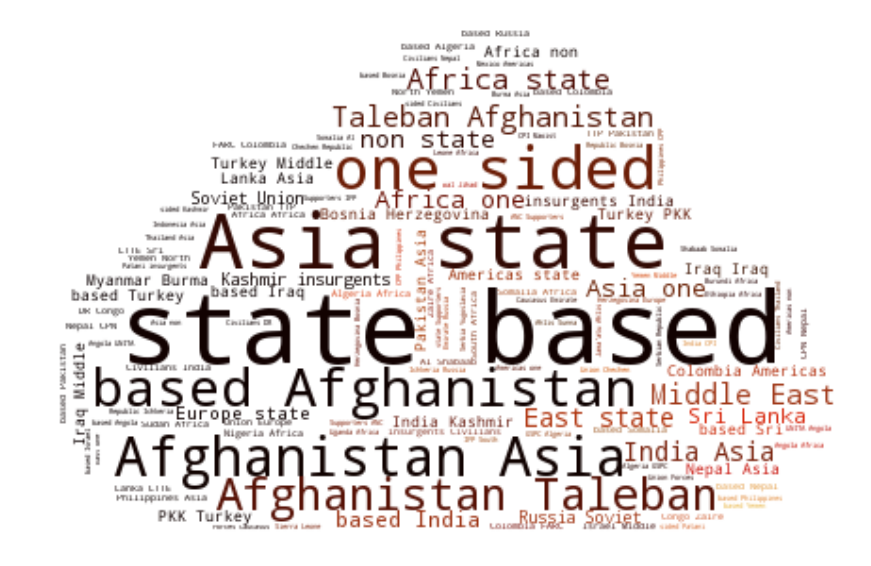

In [185]:
stopwords = set(STOPWORDS)
stopwords.add("Government")  # It is a very common word in every conflict side name

# Sample the colours from an image
colouring = np.array(Image.open("colour-samples.jpg"))
image_colors = ImageColorGenerator(colouring)
# Draw the word cloud in a particular shape
mask = np.array(Image.open("mask.jpg"))

# Generate word cloud
wc = WordCloud(background_color="white", max_words=20000, mask=mask, stopwords=stopwords, random_state=42)
wc.generate(conflict_dataset_terms)

plt.figure(figsize=(15, 10))
plt.imshow(wc.recolor(color_func=image_colors), interpolation='bilinear')
plt.axis("off")
plt.show()